__Photon Calibration Demo Notebook__

This is a demo notebook/tutorial for the PhotonCalibration class developed in the Fall of 2023 by Roger Romani. Feel free to reach to Roger with questions, or other members of the group if Roger has graduated.

Why would you want to use the PhotonCalibration object? In short because you want to understand the pulse shape of photons being used for a calibration, and things like the energy contained in the template. You could use many of these functions for general pulse shape fitting, but this package was specifically designed for photon calibrations, so will be most useful for that.

First, let's import some packages

In [1]:
import numpy as np
import vaex as vx
from matplotlib import pyplot as plt
from detanalysis import Analyzer, Semiautocut, MasterSemiautocuts

import scipy as sp

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [10, 6.5]

import qetpy as qp
import scipy as sp
import pandas as pd
import random
import pickle

import pytesdaq.io as h5io
import math
import qetpy as qp
import git

from qetpy.core.didv._uncertainties_didv import get_power_noise_with_uncertainties, get_dPdI_with_uncertainties
from qetpy.core import calc_psd
from detanalysis import PhotonCalibration
from scipy.fftpack import fft, ifft, fftfreq

from pytesdaq.io.hdf5 import H5Reader
import pytesdaq.io.hdf5 as h5io
h5 = h5io.H5Reader()

Now, to give us some data to work with, let's import some data from Run 28. To check we know what data's what, I'll first print out the metadata comment so we know what devices we're trying to calibrate.

In [2]:
path_to_data = '/sdata1/runs/run28/raw/demo/continuous_I2_D20230630_T192244'
path_to_all_data = '/sdata1/runs/run28/'
events, metadata = h5.read_many_events(path_to_data, nevents=5, adctoamp=True, include_metadata=True)

print(metadata[0]['group_comment'])

"405nm laser no attenuator 4.42V to 3V 100 ns targeting 1%,4% single photon"


Now, let's import the actual data. In this case, as described above we'll be working with 405 nm laser data at an intensity designed to calibrate the 1% and 4% devices.

This data was externally triggered on a function generator, so we know exactly when all our pulses start already. This is one of the key features of the data that lets us do precision studies of pulse shapes

In [3]:
myanalyzer_405b = Analyzer('/sdata1/runs/run28/raw/demo/processed/continuous_I2_D20230630_T192244/feature_I2_D20230705_T113952')
myanalyzer_405b.describe()
df_405b = myanalyzer_405b.df

Number of files: 2
Number of events: 31470
Number of features: 97
Is DataFrame filtered? False
No cuts have been registered!
No derived features have been added!


Before working with this data, we need to cut it to get good quality data. These cuts are done with Semiautocuts and MasterSemiautocuts. I won't go into detail about what's going on here, see the Semiautocuts tutorial/demo notebook for more information.

In [4]:
##First, the 4% cuts

cut_pars_baseline = {'sigma_upper':1.0}


baseline_cut_4pc = Semiautocut(df_405b, cut_rq = 'baseline', channel_name='Melange4pc1ch',
                               cut_pars=cut_pars_baseline)
bcut_mask = baseline_cut_4pc.do_cut(lgcdiagnostics=False)

df_405b['slope_Melange4pc1ch'] = df_405b['baseline_Melange4pc1ch'] - df_405b['baseline_end_Melange4pc1ch']


cut_pars_slope = {'sigma': 2.0}

slope_cut = Semiautocut(df_405b, cut_rq = 'slope', channel_name='Melange4pc1ch',
                               cut_pars=cut_pars_slope)
slopecut_mask = slope_cut.do_cut(lgcdiagnostics=False)

cut_pars_chi2 = {'percent':0.9}

ofamp_limits = [-0.1e-7, 0.0, 1e-7]
exceptions_dict = {0: {'val_lower': 900, 'val_upper': 1100}, 1: {'val_lower': 900, 'val_upper': 1100}}

chi2_cut = Semiautocut(df_405b, cut_rq = 'lowchi2_of1x1_nodelay', channel_name='Melange4pc1ch',
                               cut_pars=cut_pars_chi2, ofamp_bins = ofamp_limits, 
                       exceptions_dict=exceptions_dict)

chi2cut_mask = chi2_cut.do_cut(lgcdiagnostics=False, 
                                   include_previous_cuts=['cut_baseline_Melange4pc1ch', 'cut_slope_Melange4pc1ch'])
chi2_cut.get_passage_fraction(lgcprint=True)



cuts_list_4pc = ['cut_baseline_Melange4pc1ch',
            'cut_slope_Melange4pc1ch',
            'cut_lowchi2_of1x1_nodelay_Melange4pc1ch']

MSAC_4pc = MasterSemiautocuts(df_405b, cuts_list_4pc, 'Melange4pc1ch')
MSAC_4pc.combine_cuts()

Cut name: cut_lowchi2_of1x1_nodelay_Melange4pc1ch
Passage fraction: 0.9652685096917699 (Triggers and Randoms)
Number of events passing cuts: 30377 (Triggers and Randoms)
Number of events failing cuts: 1093 (Triggers and Randoms)
Number of total events: 31470 (Triggers and Randoms)
 


In [5]:
# Second, the 1 percent cuts

cut_pars_baseline = {'val_upper':-1.43e-7}


baseline_cut_1pc = Semiautocut(df_405b, cut_rq = 'baseline', channel_name='Melange1pc1ch',
                               cut_pars=cut_pars_baseline)
bcut_mask = baseline_cut_1pc.do_cut(lgcdiagnostics=False)

df_405b['slope_Melange1pc1ch'] = df_405b['baseline_Melange1pc1ch'] - df_405b['baseline_end_Melange1pc1ch']


cut_pars_slope = {'sigma': 1.0}

slope_cut = Semiautocut(df_405b, cut_rq = 'slope', channel_name='Melange1pc1ch',
                               cut_pars=cut_pars_slope)
slopecut_mask = slope_cut.do_cut(lgcdiagnostics=False)

cut_pars_chi2 = {'percent':0.9}

ofamp_limits = [-0.1e-7, 0.0, 1e-7]
exceptions_dict = {0: {'val_lower': 900, 'val_upper': 1100}, 1: {'val_lower': 900, 'val_upper': 1100}}

chi2_cut = Semiautocut(df_405b, cut_rq = 'lowchi2_of1x1_nodelay', channel_name='Melange1pc1ch',
                               cut_pars=cut_pars_chi2, ofamp_bins = ofamp_limits, 
                       exceptions_dict=exceptions_dict)

chi2cut_mask = chi2_cut.do_cut(lgcdiagnostics=False, 
                                   include_previous_cuts=['cut_baseline_Melange1pc1ch', 'cut_slope_Melange1pc1ch'])
chi2_cut.get_passage_fraction(lgcprint=True)

cuts_list_1pc = ['cut_baseline_Melange1pc1ch',
            'cut_slope_Melange1pc1ch',
            'cut_lowchi2_of1x1_nodelay_Melange1pc1ch']

MSAC_1pc = MasterSemiautocuts(df_405b, cuts_list_1pc, 'Melange1pc1ch')
MSAC_1pc.combine_cuts()

Cut name: cut_lowchi2_of1x1_nodelay_Melange1pc1ch
Passage fraction: 0.8492214807753415 (Triggers and Randoms)
Number of events passing cuts: 26725 (Triggers and Randoms)
Number of events failing cuts: 4745 (Triggers and Randoms)
Number of total events: 31470 (Triggers and Randoms)
 


To model the electrical response of our TESs to thermal power inputs, we'll want to use dIdV fits (to construct a dPdI). Here, we're importing dIdV objects that have already been fit and saved. See the dIdV tutorial/demo notebook for more details.

In [6]:
with open("didvresult_4_0630.pickle", 'rb') as handle:
    result_4 = pickle.load(handle)

with open("didvresult_1_0630.pickle", 'rb') as handle:
    result_1 = pickle.load(handle)

Architecturally, the photon calibration works by:
- Fitting the spectrum of an energy like RQ, to know where to get pulses from which represent the e.g. first, second, etc. photon peaks
- Getting pulses from around the peak of those fit photon peaks.
- Constructing a dPdI model from a dIdV fit in order to be able to fit the pulse shape in the power domain.
- Converting the set of loaded pulses into the frequency and then power domain, and then using the set of loaded pulses to find the mean and standard deviation in the pulse imaginary and real components at every frequency.
- Fitting a model to this data in the frequency/power domain. The advantage of this approach is it allows for the noise differing in different frequency bins to be correctly accounted for, while allowing you to intuitively visualize the actual power hitting the TES (when in the power and time domain).
- Save the fit parameters and covariance matrix for this model, so that different templates with different dIdVs can be calculated later.

Ok, let's begin. Let's initialize our PhotonCalibration object. Let's start by working with the 4% calibrations.

Two of the things we have to define are the energy of the photons being used for the calibration (in our cade 405 nm which is 3.061 eV) and the model which will be fit to the pulse data. In this case, we're choosing a "twopulse" model, which is composed of the sum of two pulses which share the same rise time. This can be changed later if desired.

In [7]:
cal_4pc = PhotonCalibration(template_model="twopulse",
                            photon_energy_ev=3.061,
                            analyzer_object=myanalyzer_405b,
                            didv_result=result_4,
                            channel_name='Melange4pc1ch')

The first thing to do once we've created a PhotonCalibration object is to fit to a spectrum of an "energy-like" RQ (e.g. OFAmp) to be able to select events associated with absorbing zero photons, one photon, two photons... We can fit a number of models to the spectrum, but in this case we're chosing the sum of three gaussians.

Event heights: [ 4.64005766e-09  3.54985235e-09  1.09614952e-08 ... -7.79372478e-11
 -2.91869201e-09  2.20201712e-10]
Number of events: 24532
 
Guess: [400, 0.0, 1e-09, 220, 5.5e-09, 1.2e-09, 60, 1.1e-08, 1.35e-09]


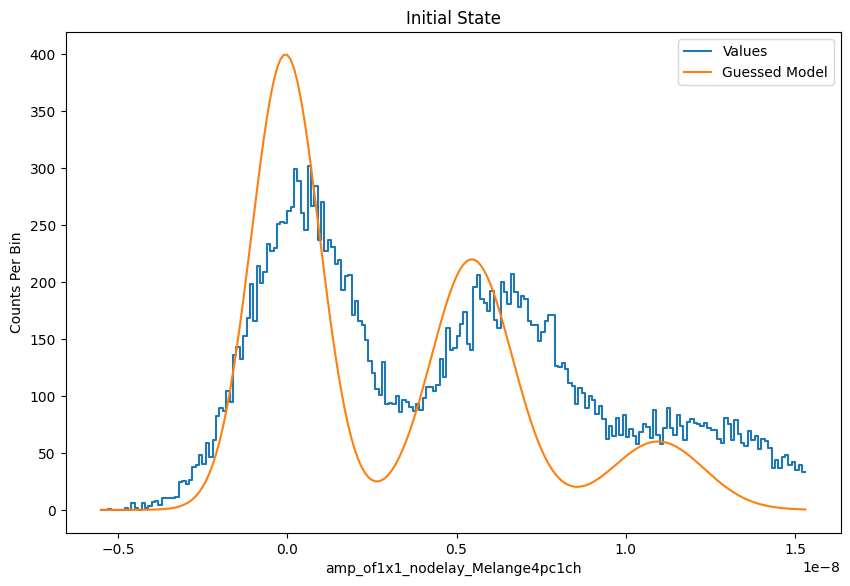

Guess: [400, 0.0, 1e-09, 220, 5.5e-09, 1.2e-09, 60, 1.1e-08, 1.35e-09]
Bounds lower: [200.0, -5e-10, 7.500000000000001e-10, 110.0, 2.75e-09, 9e-10, 30.0, 5.5e-09, 1.0125e-09]
Bounds upper: [600.0, 5e-10, 1.25e-09, 330.0, 8.25e-09, 1.5e-09, 90.0, 1.65e-08, 1.6875000000000002e-09]
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.1281e+03                                    4.10e+03    
       1              2         1.3906e+03      1.74e+03       7.32e+01       3.36e+03    
       2             14         1.3894e+03      1.27e+00       6.20e-11       3.23e+03    
       3             26         1.3894e+03      0.00e+00       0.00e+00       3.23e+03    
`xtol` termination condition is satisfied.
Function evaluations 26, initial cost 3.1281e+03, final cost 1.3894e+03, first-order optimality 3.23e+03.
     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [-0.000e+0

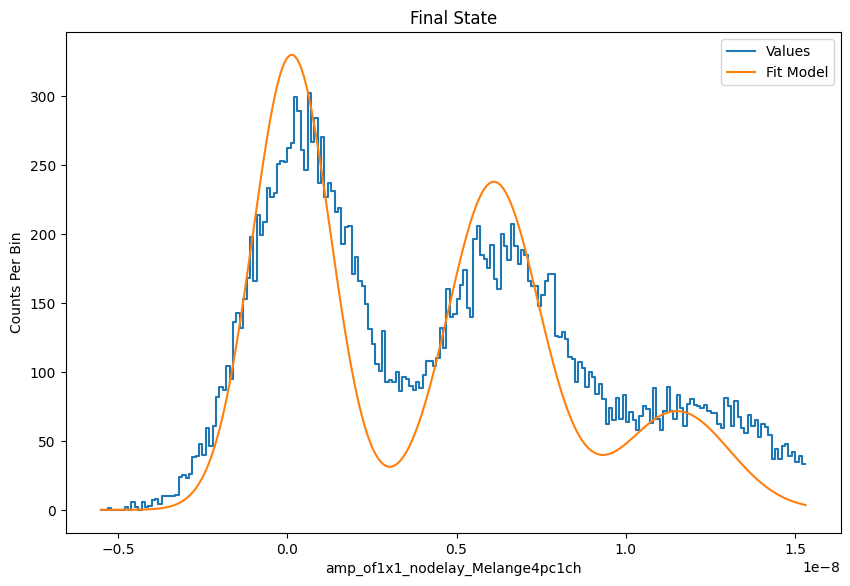

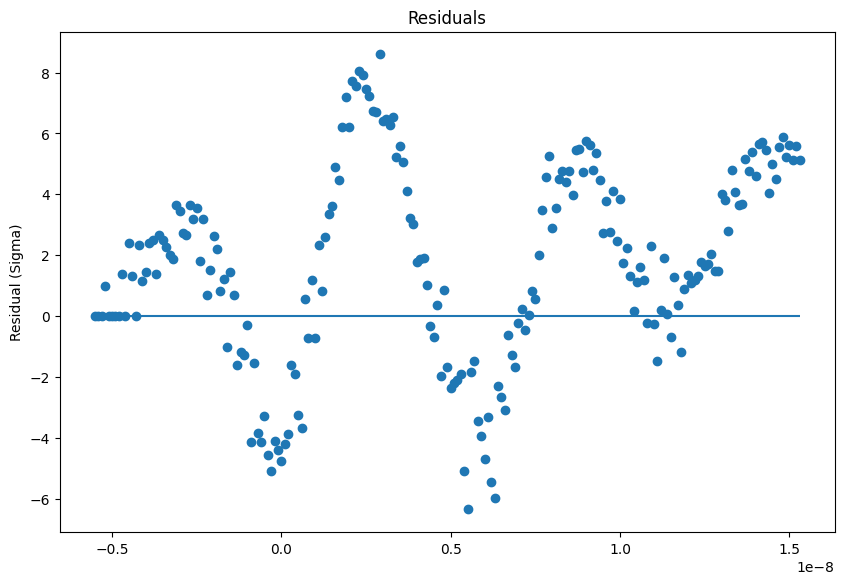

 
-----------
Fit Results: 
Gaussian 1:
Peak height: 329.98460857761523 +/- 5.207221049847753
Peak mean: 1.8457739923829396e-10 +/- 1.8576277973213464e-11
Peak width: 1.1458395980478981e-09 +/- 2.1095197397581104e-11
 
Gaussian 2:
Peak height: 237.78193131092044 +/- 14.95209730047811
Peak mean: 6.152023653966105e-09 +/- 7.205425431423379e-11
Peak width: 1.346230917791767e-09 +/- 2.336826700479624e-11
 
Gaussian 3:
Peak height: 71.52817420799542 +/- 11.357020283511554
Peak mean: 1.1559330536616696e-08 +/- 9.523829531255922e-10
Peak width: 1.5421607712735512e-09 +/- 5.235980950083226e-11
 


In [8]:
#defines the guess for the three gaussians dimensions
#order: height, mean, width, for each gaussian in turn
guess_3gaus = [400, 0.0, 1.0e-9,
                220, 0.55e-8, 1.2e-9,
                60, 1.1e-8, 1.35e-9]

_ = cal_4pc.fit_spectrum('amp_of1x1_nodelay_Melange4pc1ch', #the name of the "energy-like" RQ we'll be fitting
                         'cut_all_Melange4pc1ch', #the cut to apply to the data, we created this above
                         lgc_plot=True, lgc_diagnostics=True, #these can be turned off as desired
                         model = "three_gaus", #see the code for other options, including a Possion model
                         lgc_ylog=False, #of the diagnostic plots
                         guess = guess_3gaus,
                         bounds=None, #automatically created if None
                         bins = np.arange(-0.55e-8, 1.55e-8, 1e-10), #used for the fitting and plots
                         )

After fitting to the spectrum, we can use these fits to define regions where we can select events/traces associated with zerro/one/two... photons.

In our case, especially for the two photon peak, we need to be careful not to select a region around the peak that's too large, or we'll start biasing our template to the lower energy side of the peak, since there are more events there (leaking from the one photon peak).

We select which peak to select, what to name the cut, and how wide (in sigma) to accept events around the peak.

Peak center: 1.8457739923829396e-10
Width to cut: 8.593796985359236e-10
 
Modified cut name: cut_0p
 


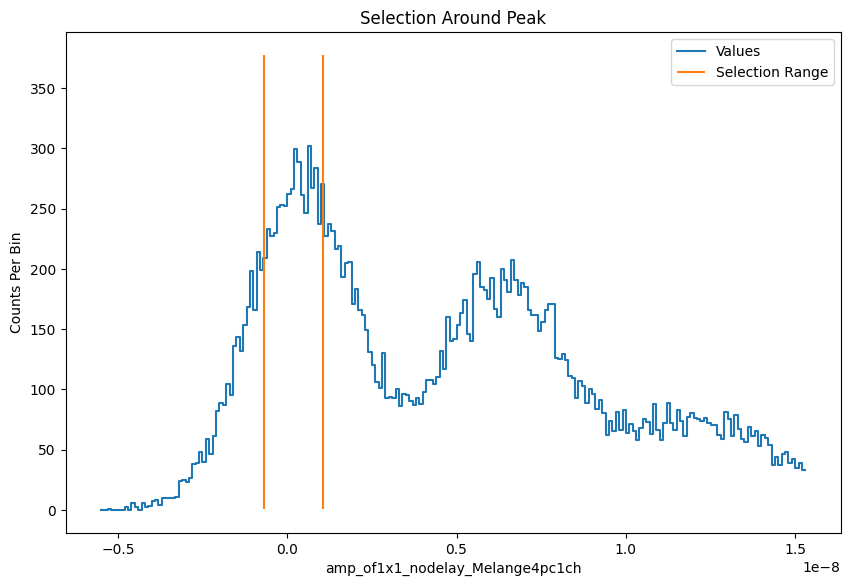

include_previous_cuts: False
 
 
include_previous_cuts: False
Using default cut parameters
Selection list: ['_lims_mask']
Cut parameters: {'val_lower': -6.748022992976297e-10, 'val_upper': 1.0439570977742175e-09}
Number of events passing selection: 31470
Lower limit for cuts: -6.748022992976297e-10
Upper limit for cuts: 1.0439570977742175e-09


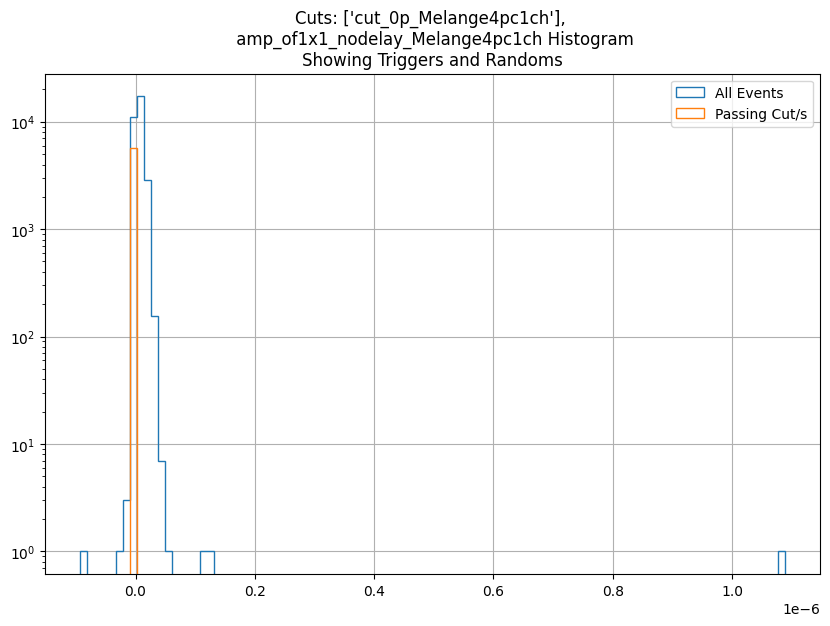

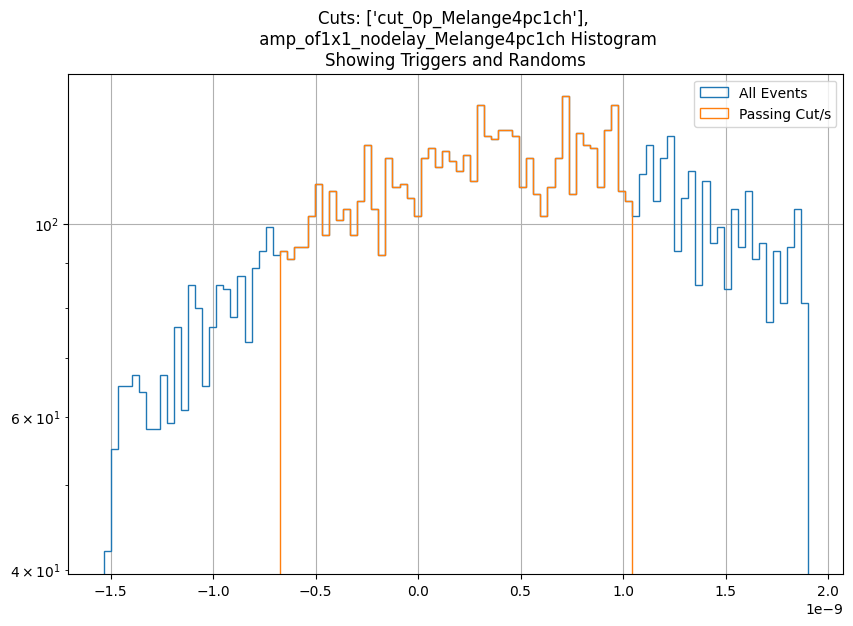

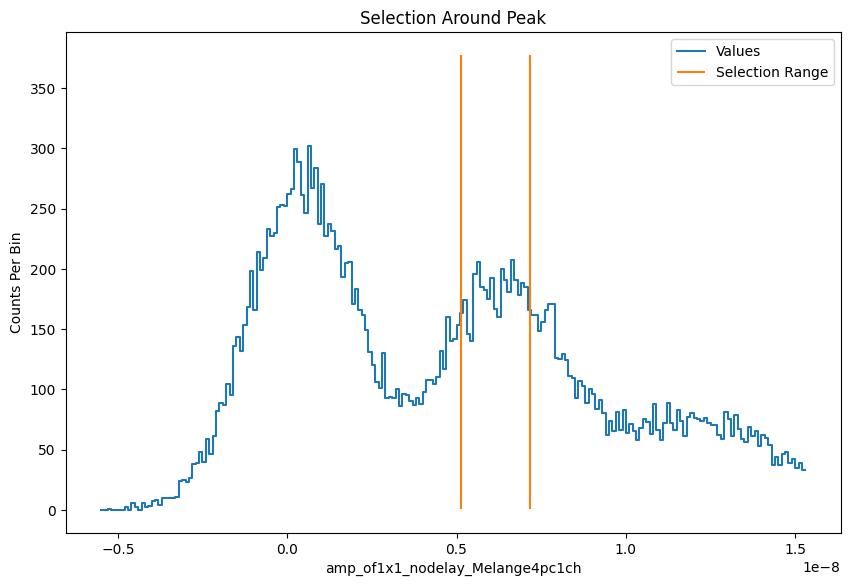

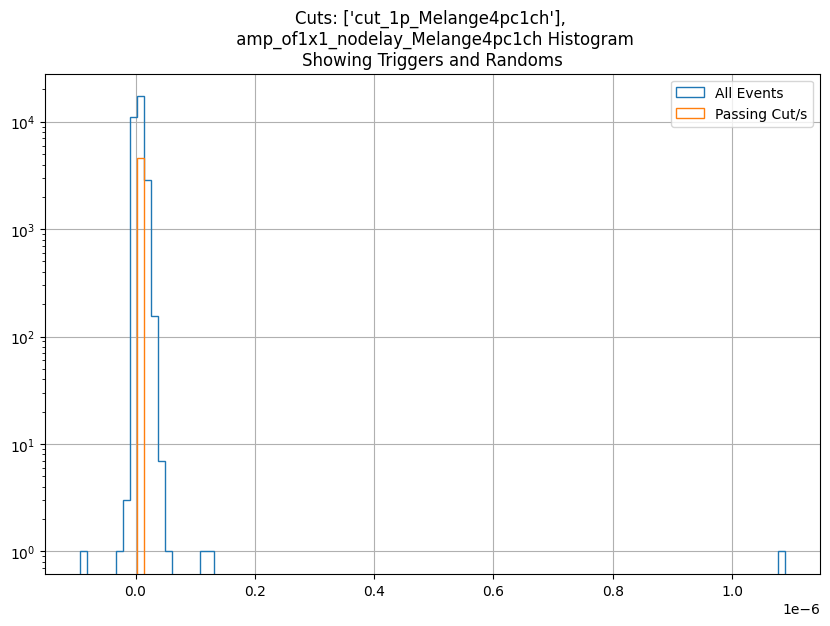

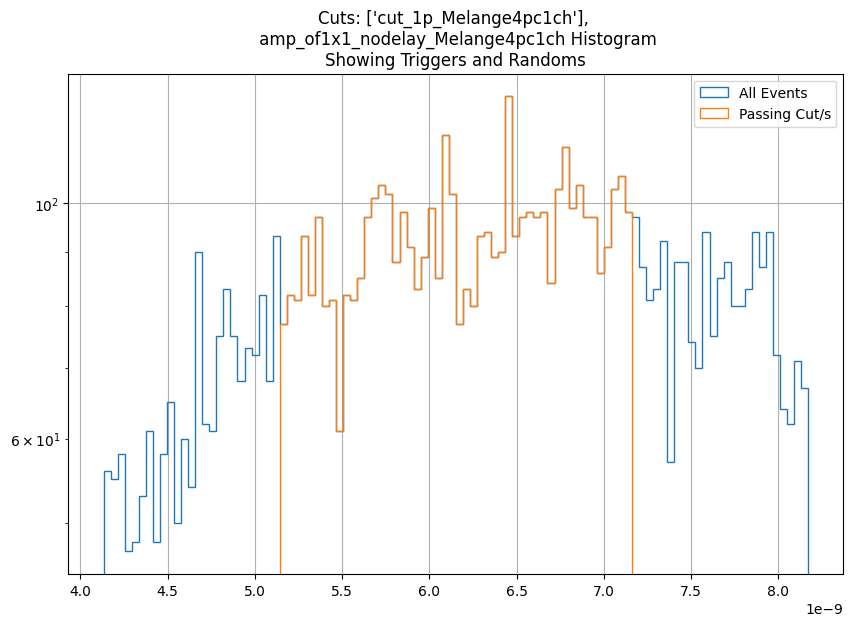

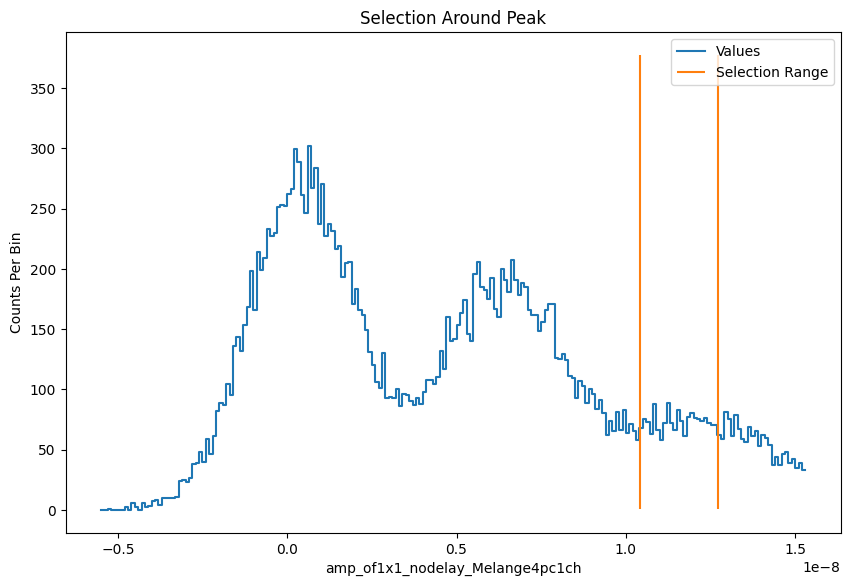

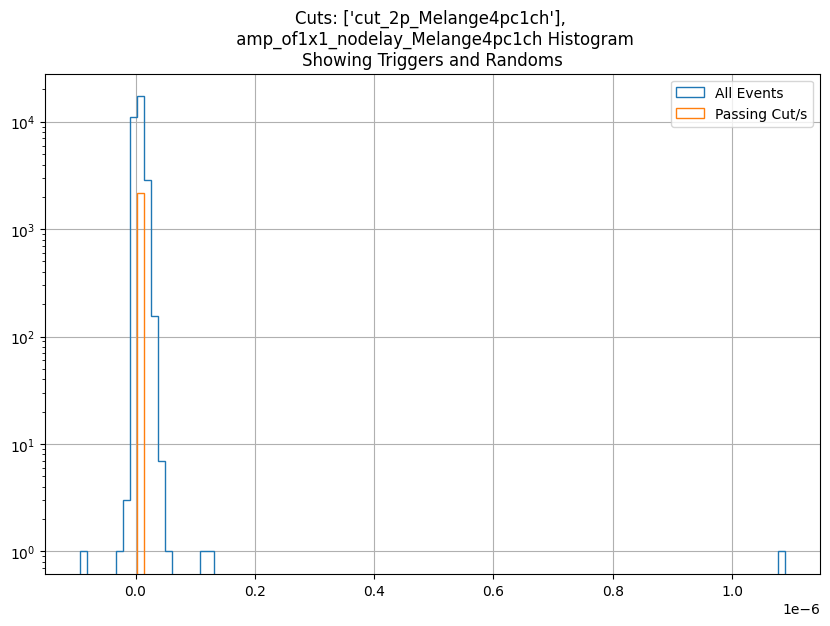

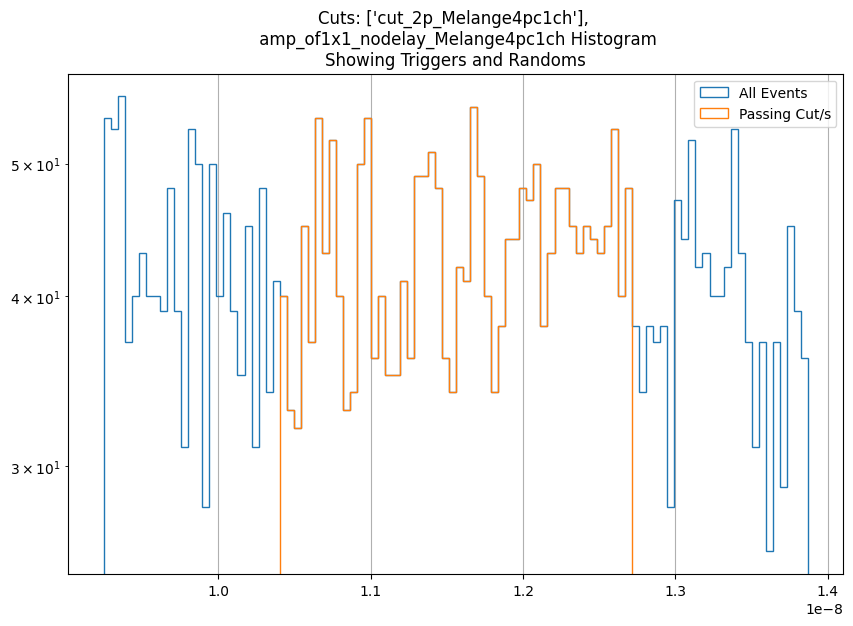

In [9]:
#zero photon selection
cal_4pc.define_photon_cut(0, #photon peak number
                          0.75, #width to accept (in sigma)
                          'cut_0p_Melange4pc1ch', #the cut name, best to standardize as this or similar
                          lgc_plot=True, lgc_ylog=False, #can be turned off
                          lgc_diagnostics=True)

#one photon selection
cal_4pc.define_photon_cut(1, 0.75, 'cut_1p_Melange4pc1ch', 
                          lgc_plot=True, lgc_ylog=False, 
                          lgc_diagnostics=False)

#two photon selection
cal_4pc.define_photon_cut(2, 0.75, 'cut_2p_Melange4pc1ch', 
                          lgc_plot=True, lgc_ylog=False, 
                          lgc_diagnostics=False)

Now we can actually load the traces in these regions into the PhotonCalibration object. 

There may not actually be 1000 events to load in some of these regions, if so the PhotonCalibration object should load all that it can and handle everything correctly.

INFO: Number of events found = 1000
INFO: Number of events found = 1000
Photon cut name: cut_2p_Melange4pc1ch
INFO: Number of events found = 1000


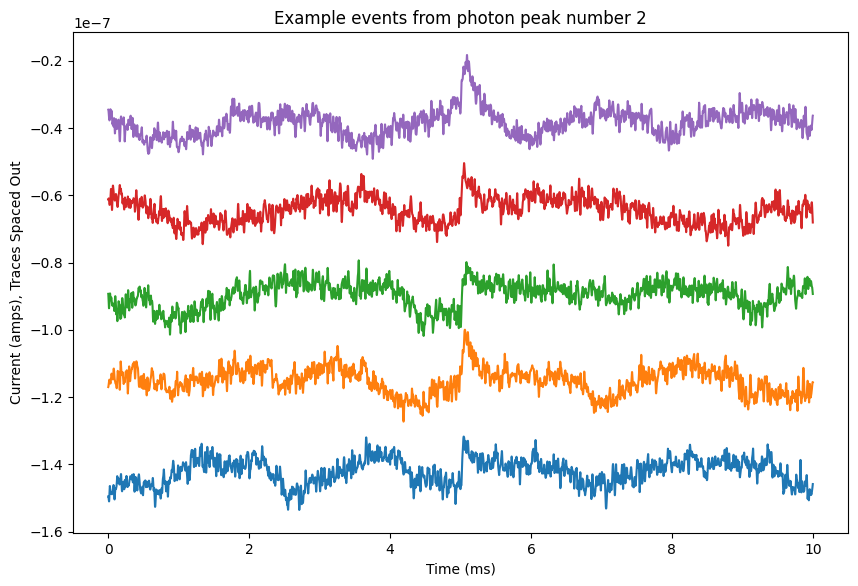

In [11]:
cal_4pc.load_events(0, #photon peak to load
                    number_events_limit=1000,
                    pretrigger_window=5e-3, trace_length=10e-3,  
                    raw_path='/sdata1/runs/run28/raw', 
                    lgc_plot_example_events=False, example_events_num=5)

cal_4pc.load_events(1, number_events_limit=1000,
                    pretrigger_window=None, trace_length=None,  
                    raw_path='/sdata1/runs/run28/raw', 
                    lgc_plot_example_events=False, example_events_num=5)

cal_4pc.load_events(2, number_events_limit=1000,
                    pretrigger_window=None, trace_length=None,  
                    raw_path='/sdata1/runs/run28/raw', 
                    lgc_plot_example_events=True, #can plot example events
                    example_events_num=5)

Having loaded in these traces, we can now sum them together to make an average template.

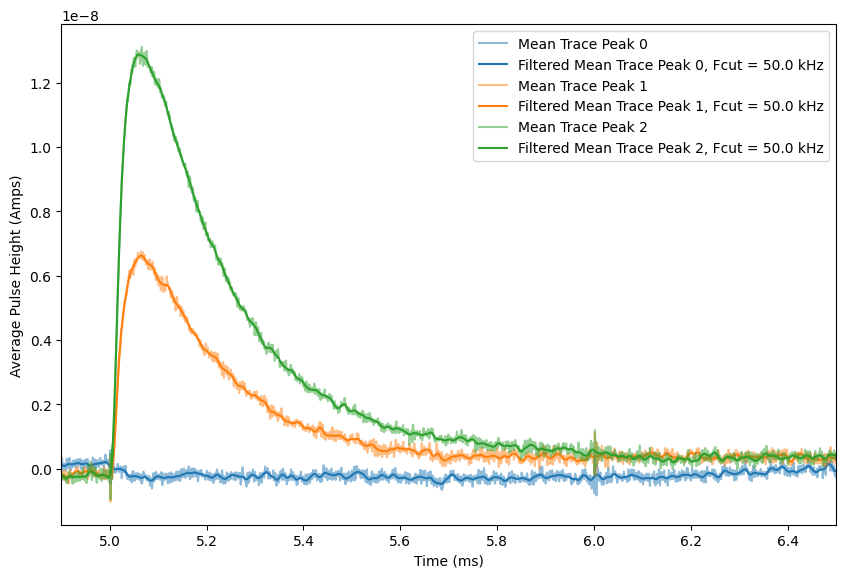

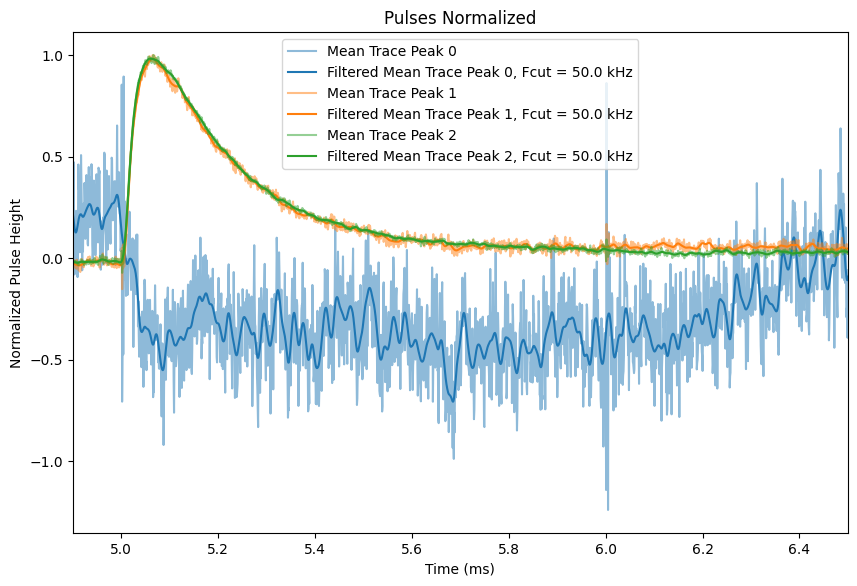

In [12]:
cal_4pc.calculate_average_pulses(lgc_plot_average_trace=True,
                                 time_lims=[4.9e-3, 6.5e-3])

In the above plots, you can notice right at 5 ms and 6 ms (when our TTL trigger square wave goes up and down) there's crosstalk in all three event templates. Before processing these templates further, we'd like to subtract this out. This functionality is built into the PhotonCalibration object.

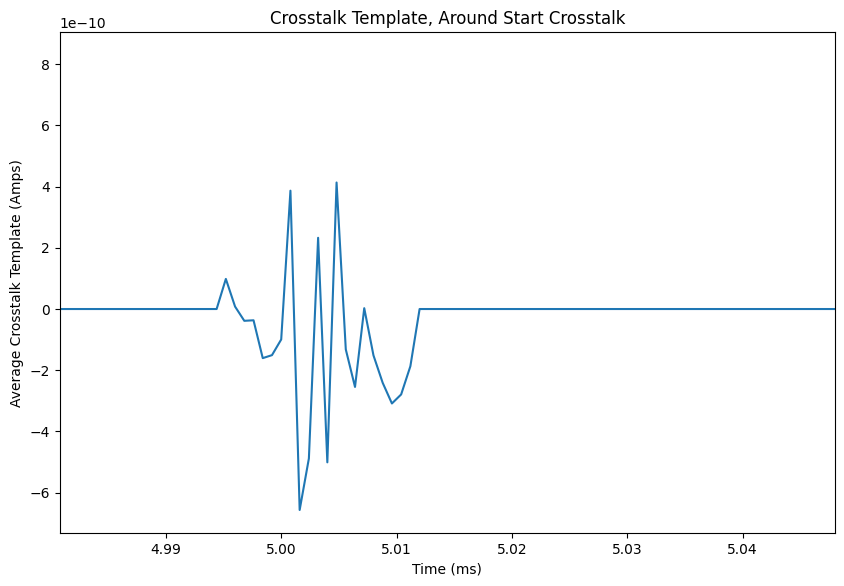

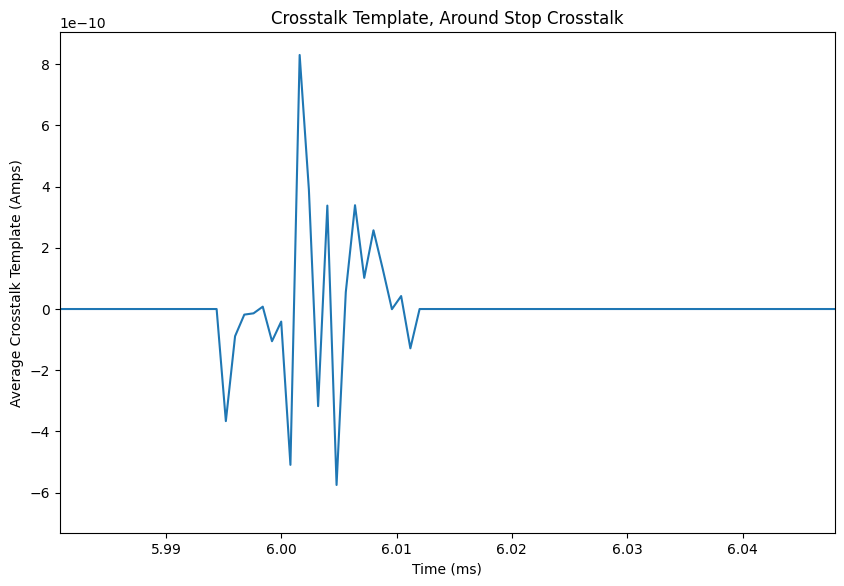

In [13]:
cal_4pc.get_crosstalk_template(crosstalk_length=1e-3, #this is the length of the TTL pulse, e.g. the time
                                                      #between crosstalk events
                               crosstalk_window_plus=15, #these are the number of bins after the trigger
                                                         #to include in the crosstalk template
                               crosstalk_window_minus=6, #these are the number of bins before the trigger
                                                          #to include in the crosstalk template
                               lgc_plot=True)

We then subtract this crosstalk templates from each of our pulses and from the averaged pulse.

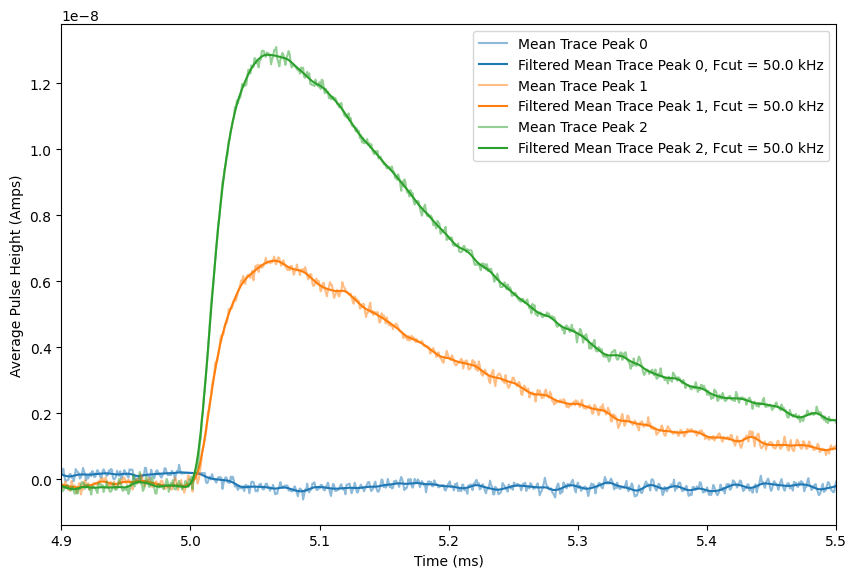

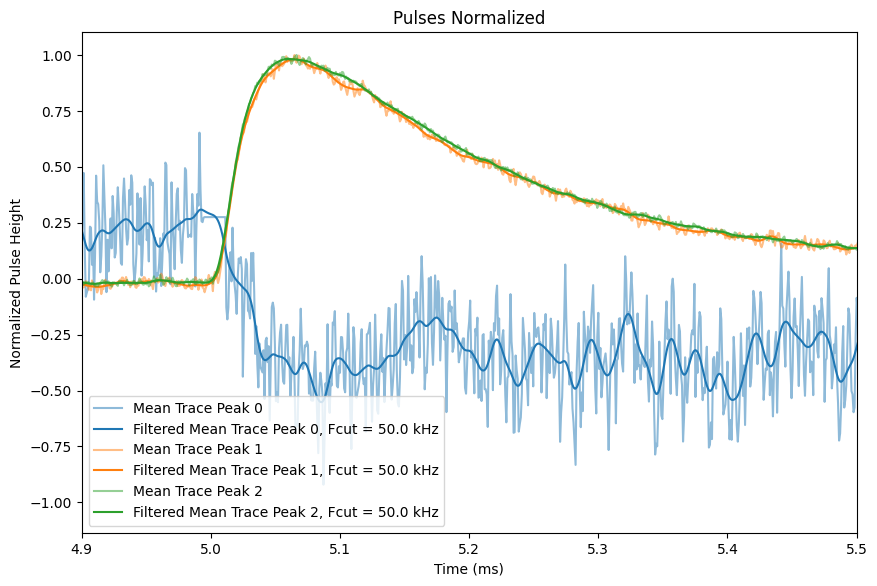

In [14]:
cal_4pc.subtract_crosstalk_template(lgc_replot_means=True)

Those mean traces look better! Now, we can calculate the dPdI and the frequency domain templates and uncertainties.

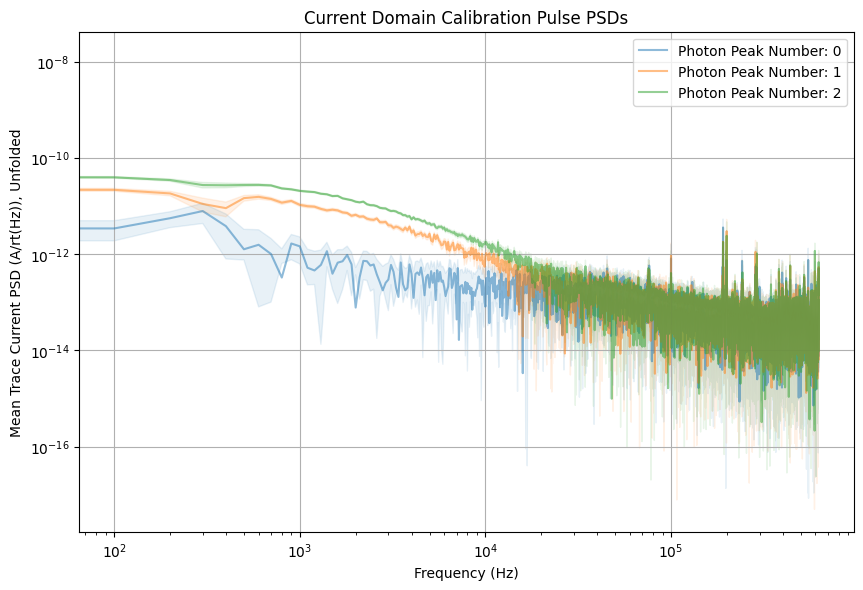

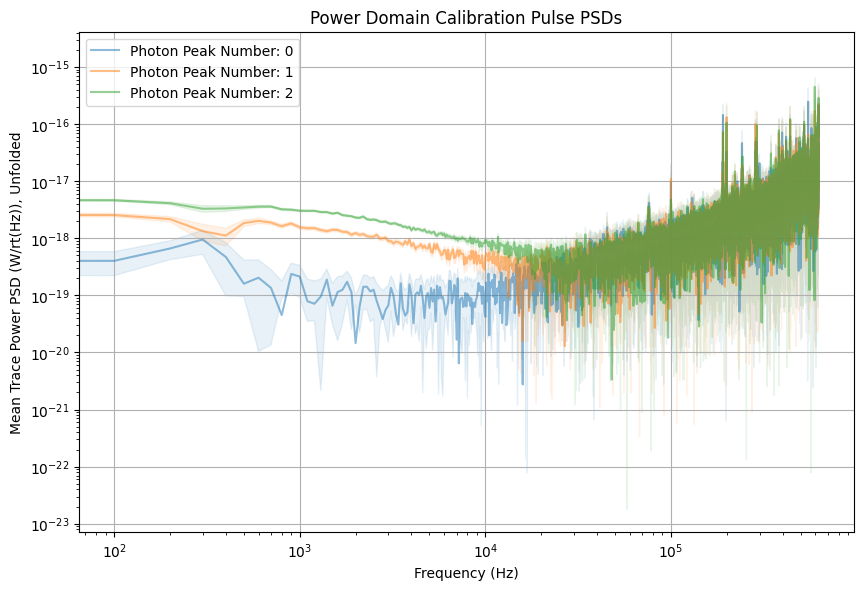

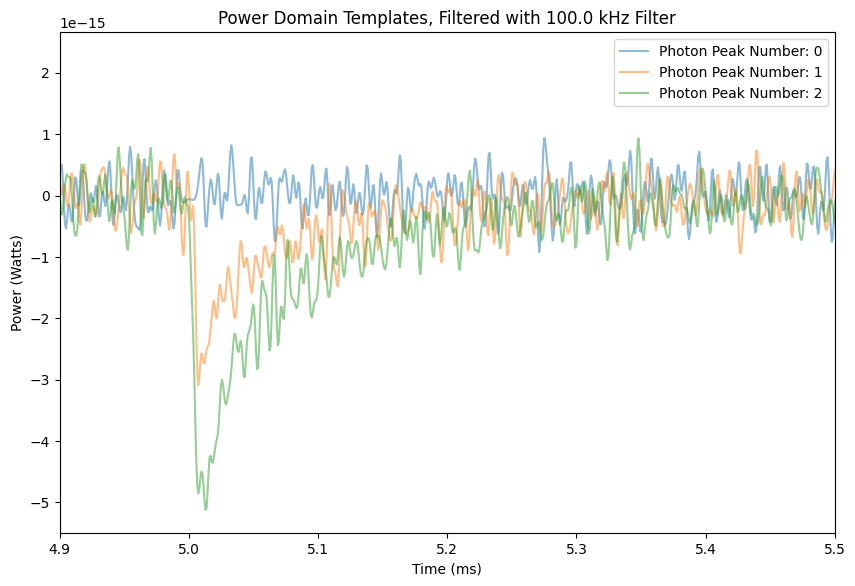

In [15]:
cal_4pc.calculate_dPdI(lgc_plot=False)
cal_4pc.calculate_frequency_domain_templates(lgc_plot=True, filter_freq=100e3)

Let's start by fitting our first photon peak power domain pulse (we'll fit the zeroth and second peak later).

To do this, we'll need to start with a reasonable guess for the shape of the photon pulse.

Guess: [1e-15, 1.5e-15, 1.5e-05, 0.00012, 5e-06]
Bounds is None


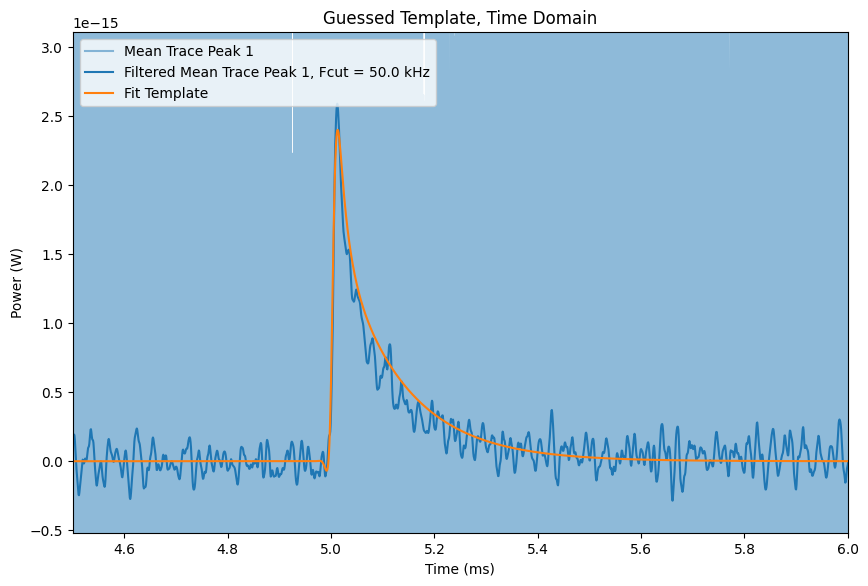

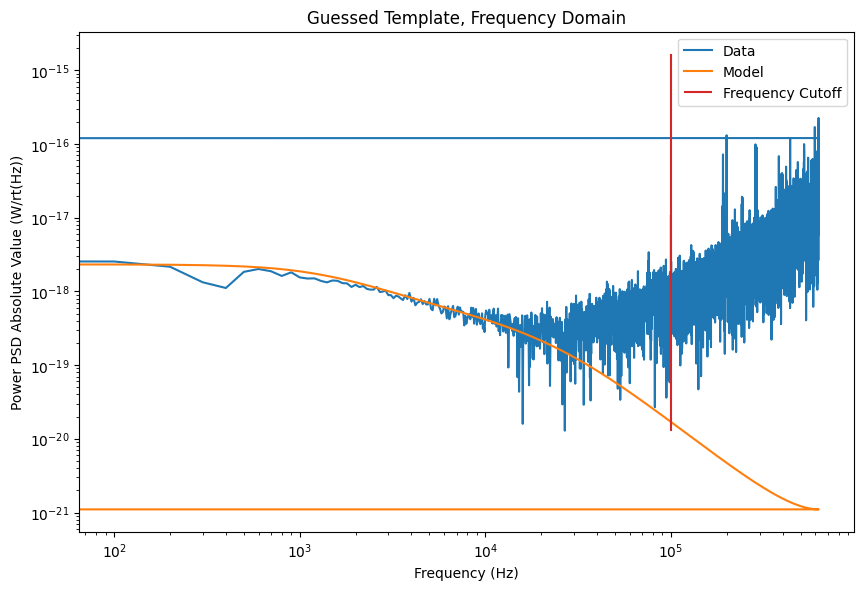

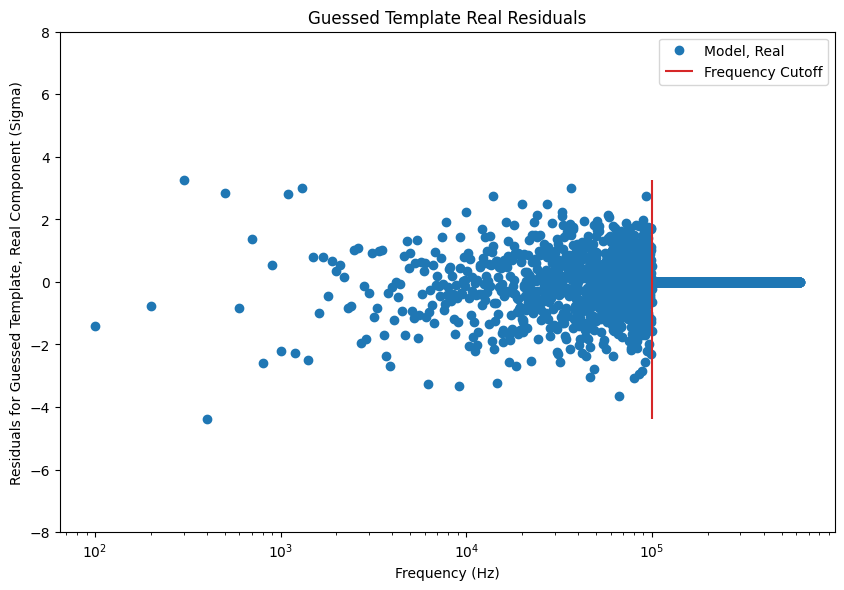

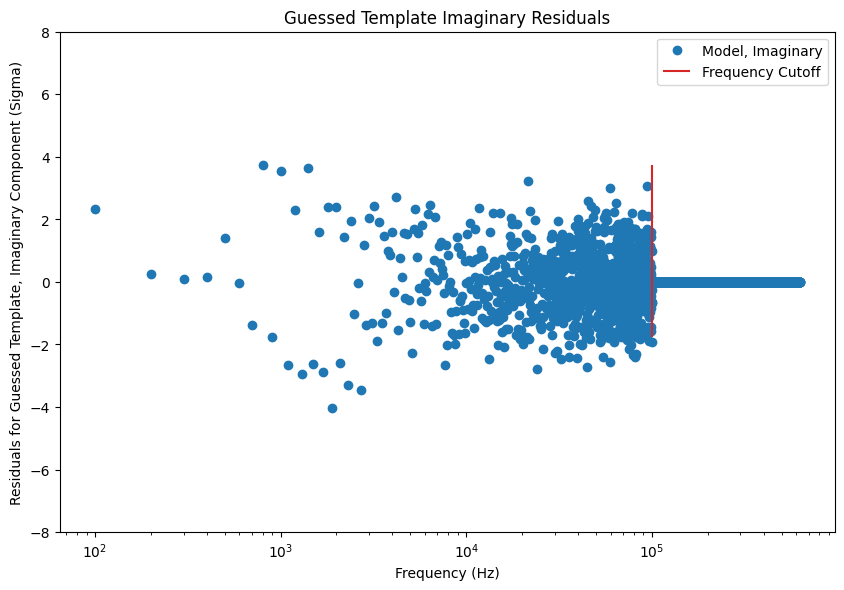

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.3212e+03                                    1.95e+18    
       1              4         2.1159e+03      2.05e+02       7.56e-06       2.65e+17    
       2              6         2.1096e+03      6.32e+00       3.78e-06       4.10e+16    
       3              8         2.1095e+03      1.62e-01       1.89e-06       3.04e+15    
       4             10         2.1095e+03      4.35e-03       9.46e-07       2.09e+14    
       5             11         2.1095e+03      2.00e-03       2.36e-07       3.40e+13    
`ftol` termination condition is satisfied.
Function evaluations 11, initial cost 2.3212e+03, final cost 2.1095e+03, first-order optimality 3.40e+13.


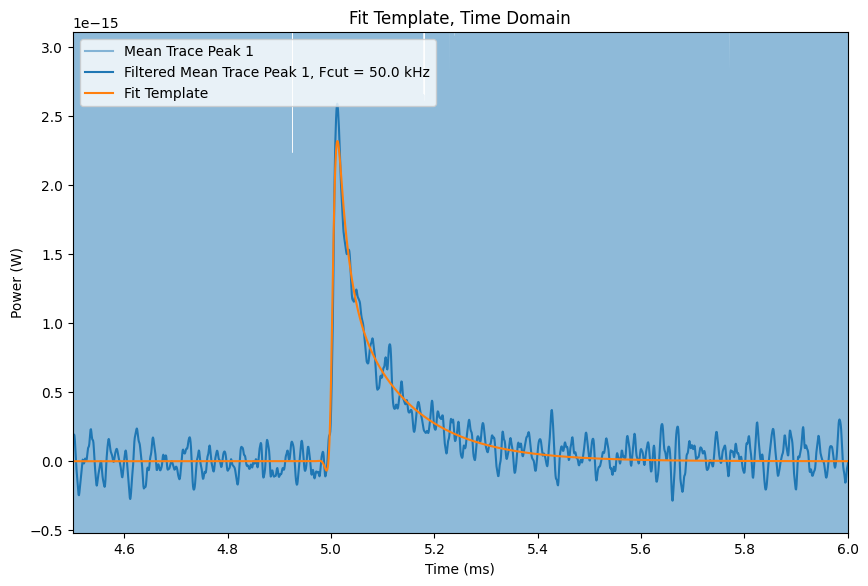

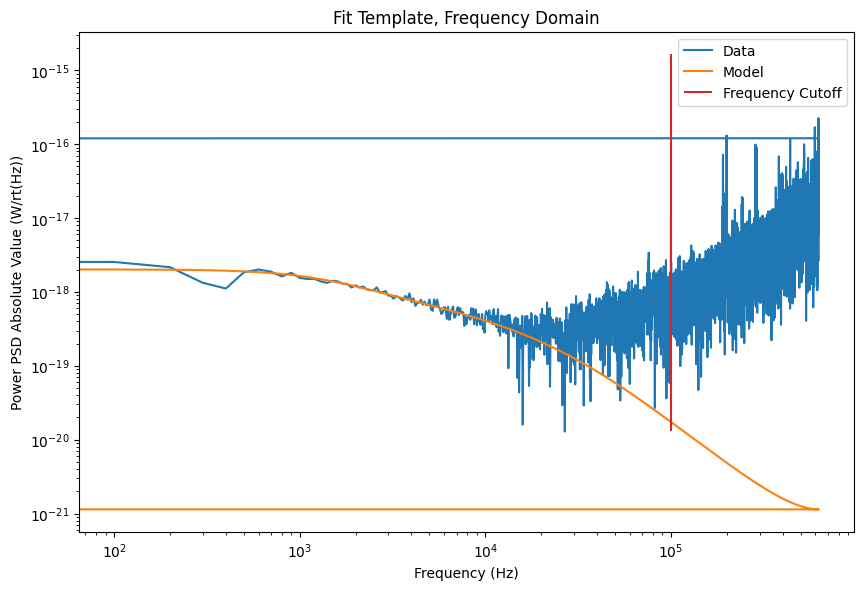

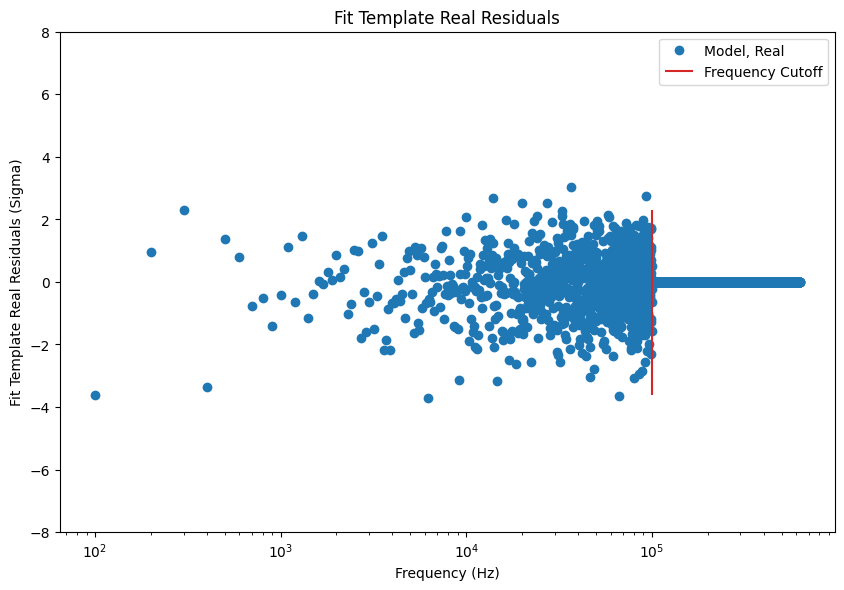

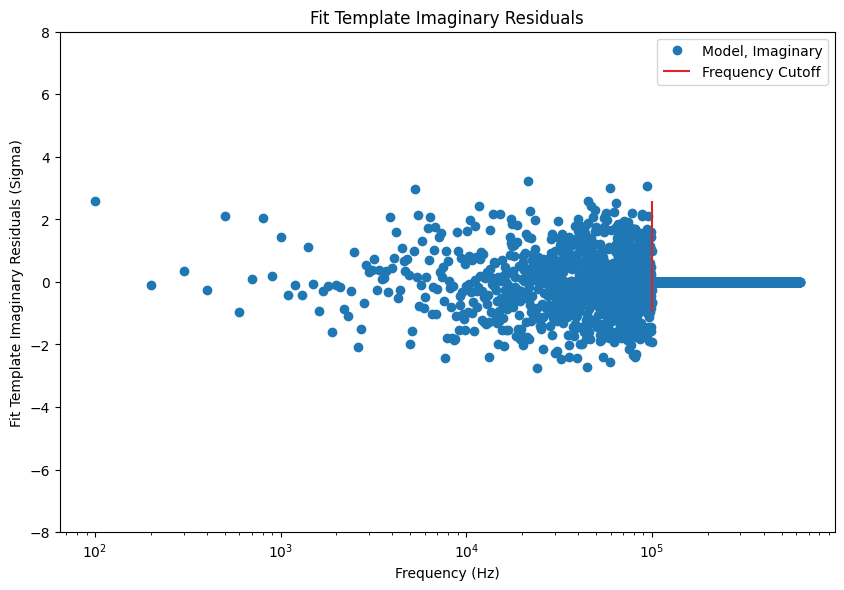

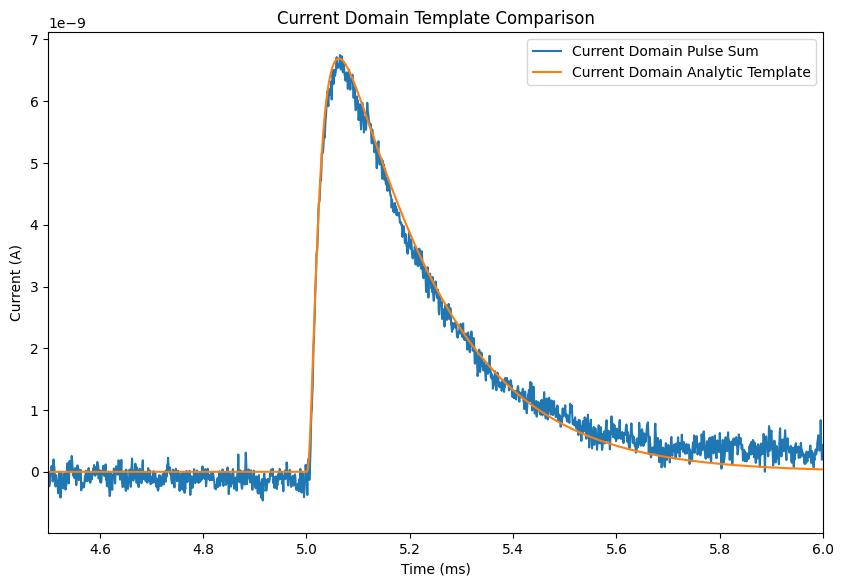

popt: 
[1.15410371e-15 1.23892077e-15 1.85036560e-05 1.19383788e-04
 4.53150258e-06]
 
cov:
[[ 2.04872893e-33 -1.14464674e-33 -2.70387686e-23  7.88982565e-23
   1.28669877e-23]
 [-1.14464674e-33  1.74181727e-33 -5.79878264e-23 -1.53344267e-22
   2.75171154e-24]
 [-2.70387686e-23 -5.79878264e-23  7.05519228e-12  8.23195211e-12
  -1.41318793e-12]
 [ 7.88982565e-23 -1.53344267e-22  8.23195211e-12  1.95841773e-11
  -1.24263781e-12]
 [ 1.28669877e-23  2.75171154e-24 -1.41318793e-12 -1.24263781e-12
   3.80260723e-13]]
 
Amplitude 1: 1.1541037127705433e-15 +/- 4.5262886869436545e-17
Amplitude 2: 1.2389207672902382e-15 +/- 4.173508437942709e-17
Fall Time 1: 18.50365602054945 +/- 2.6561611916025116 us
Fall Time 2: 119.38378767986792 +/- 4.425401372219188 us
Rise Time: 4.5315025784704455 +/- 0.6166528380618101 us


In [16]:
#order of variables: fast pulse max height, slow pulse max height, fast pulse fall time, slow pulse fall time, 
#                    rise time of both pulses
guess_1p = [1.0e-15, 1.5e-15, 15e-6, 120e-6, 5e-6]

cal_4pc.template_model = 'twopulse'
cal_4pc.fit_templates(1, #photon peak number to fit
                      guess = guess_1p, 
                      f_fit_cutoff=100e3, #above a certain frequency, basically all the template informatio
                                          #is just noise. This cutoff prevents the noise from being fit by
                                          #setting the weights to zero. This is similar to a low frequency
                                          #chi2, conceptually
                      filter_freq=50e3, #The low pass filter frequency for plotting
                      time_lims=[4.5e-3, 6e-3] #time limits for the diagnostic plots
                      )

The fit variables and covariance matrix for this fit associated with this peak are then stored as part of the PhotonCalibration object for later use.

Let's fit the zero photon peak now. I'll use bounds on the amplitude to make sure it doesn't fit the noise and get too big.

Guess: [0.0, 0.0, 1.4e-05, 0.00012, 3e-06]
Bounds lower: [-1e-18, -1e-18, 2e-06, 6e-05, 1e-06]
Bounds upper: [1e-18, 1e-18, 5e-05, 0.00016, 2e-05]


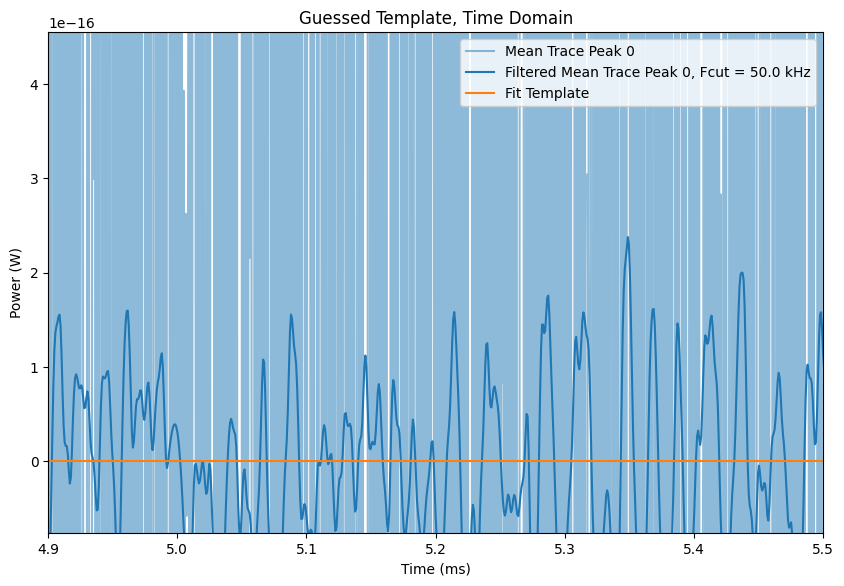

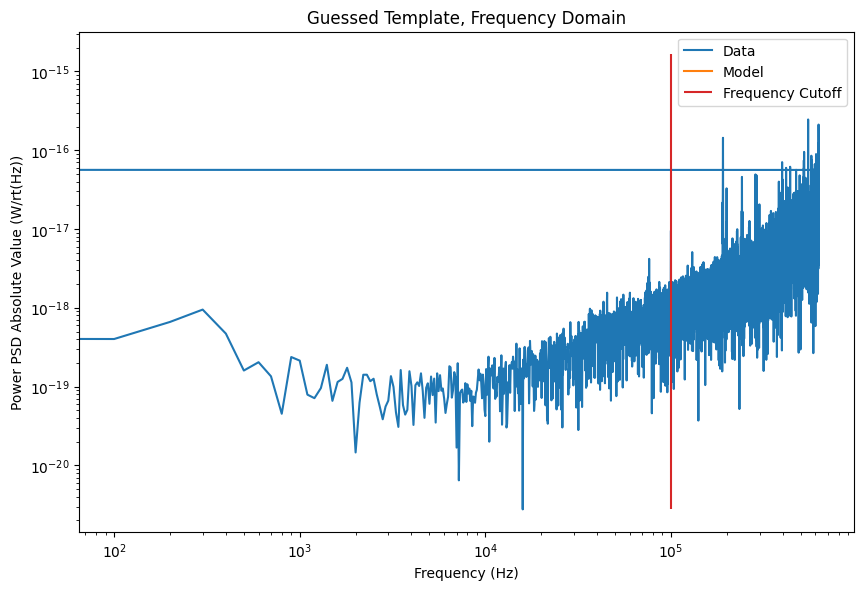

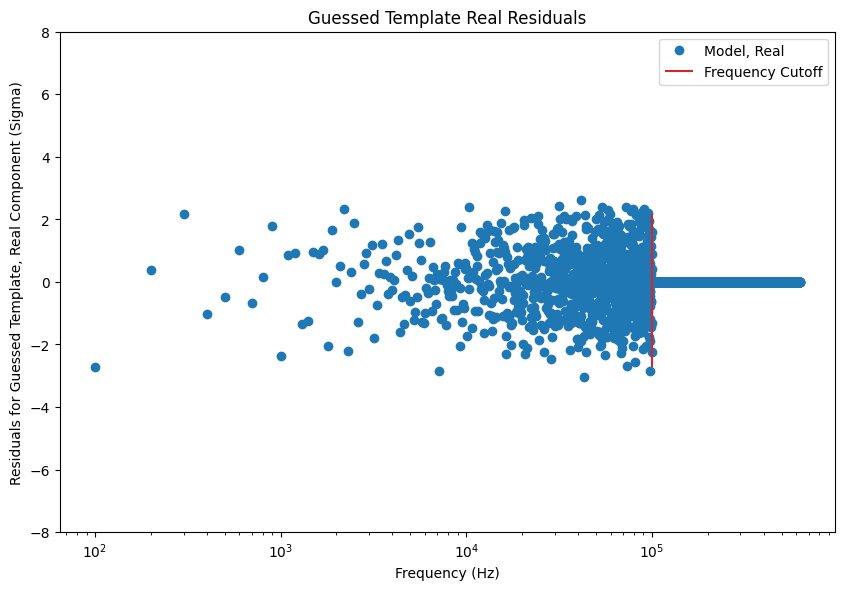

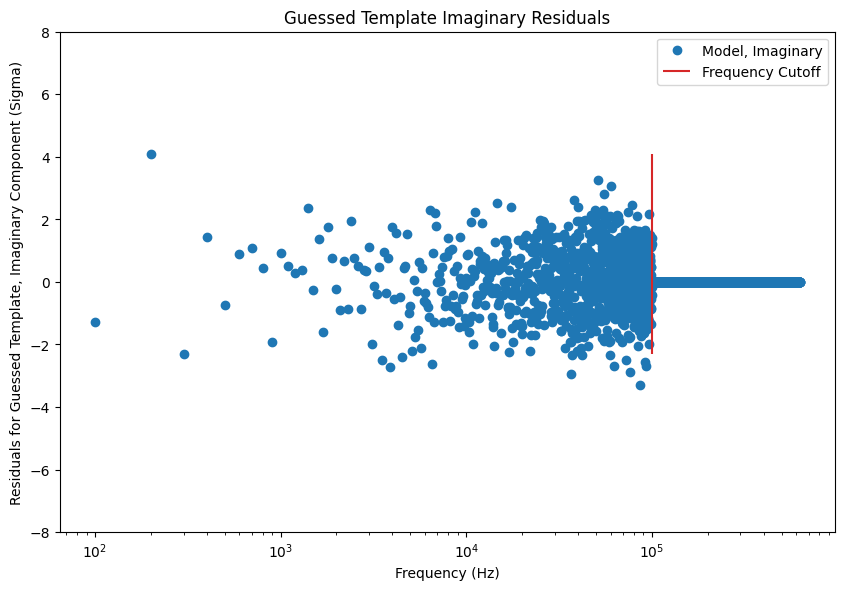

Using bounds for fit
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.1465e+03                                    8.76e-01    
       1              2         2.1455e+03      9.41e-01       1.04e-18       5.05e-01    
       2              3         2.1453e+03      2.09e-01       5.16e-07       7.78e-01    
       3              4         2.1453e+03      5.29e-02       1.11e-06       7.06e-01    
       4              5         2.1452e+03      9.43e-02       2.23e-06       5.82e-01    
       5              6         2.1450e+03      1.59e-01       4.50e-06       4.75e-01    
       6              7         2.1448e+03      2.15e-01       8.84e-06       2.43e-01    
       7              8         2.1446e+03      1.71e-01       1.64e-05       2.74e-02    
       8              9         2.1446e+03      2.55e-02       5.70e-05       8.17e-02    
       9             11         2.1446e+03      8.94e-03       2.16e-

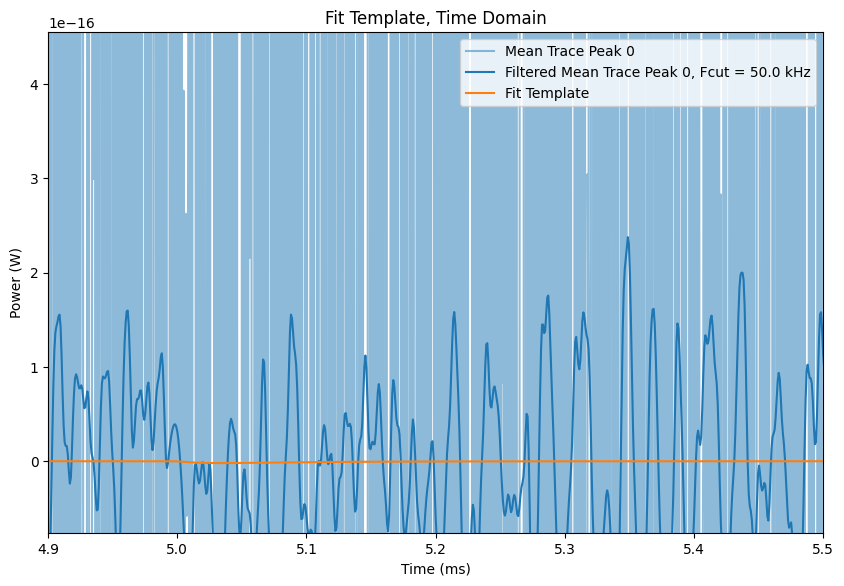

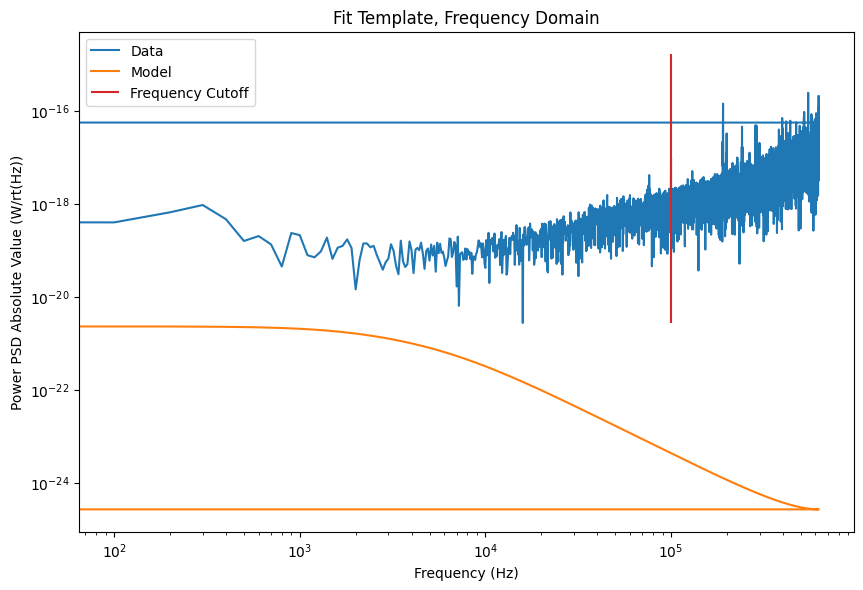

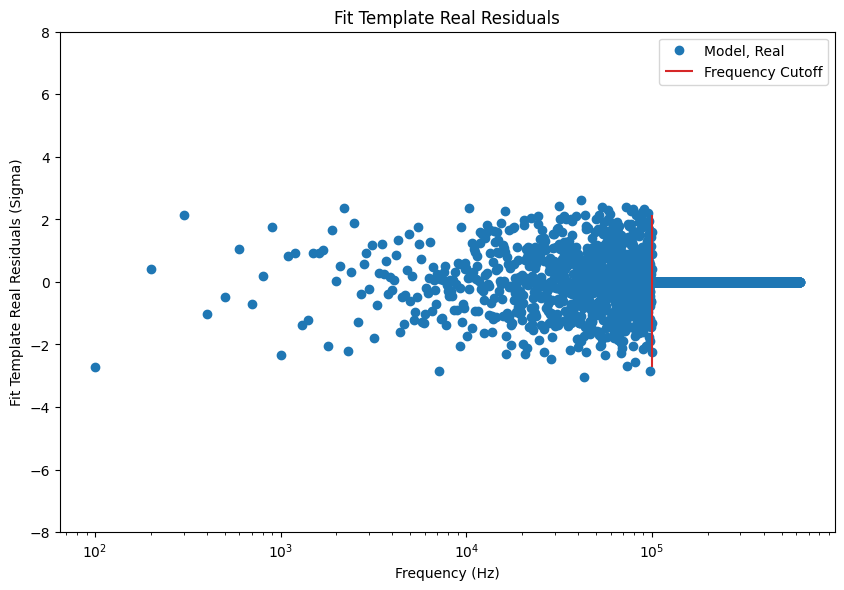

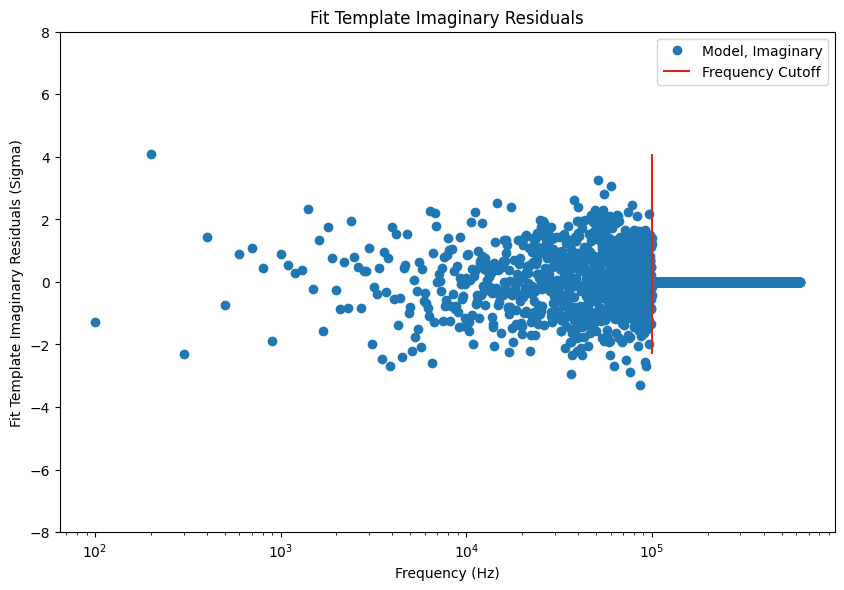

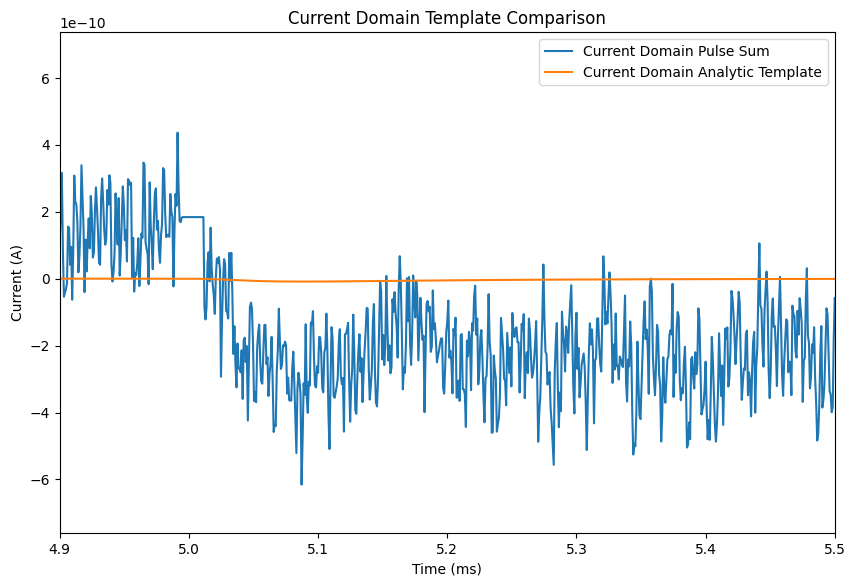

popt: 
[-1.00000000e-18 -1.00000000e-18  4.99966890e-05  9.18494634e-05
  1.99999578e-05]
 
cov:
[[ 1.70498859e-30 -1.73235795e-30 -4.07336262e-17 -4.36439971e-17
   2.53009561e-18]
 [-1.73235795e-30  1.76040328e-30  4.14598431e-17  4.43101659e-17
  -2.58216730e-18]
 [-4.07336262e-17  4.14598431e-17  1.01318554e-03  1.02656875e-03
  -6.80487873e-05]
 [-4.36439971e-17  4.43101659e-17  1.02656875e-03  1.12891877e-03
  -6.24064597e-05]
 [ 2.53009561e-18 -2.58216730e-18 -6.80487873e-05 -6.24064597e-05
   5.37424389e-06]]
 
Amplitude 1: -9.999999999999999e-19 +/- 1.3057521157680989e-15
Amplitude 2: -9.999999999999999e-19 +/- 1.3268018987621576e-15
Fall Time 1: 49.99668900349164 +/- 31830.575528512 us
Fall Time 2: 91.84946340612571 +/- 33599.386484822775 us
Rise Time: 19.999957809694468 +/- 2318.241551826895 us


In [17]:
guess_0p = [0.0e-15, 0.0e-15, 14e-6, 120e-6, 3e-6]
bounds_0p = [[-1e-18, -1e-18, 2e-6, 60e-6, 1e-6],
             [1e-18, 1e-18, 50e-6, 160e-6, 20e-6]]

cal_4pc.fit_templates(0, guess = guess_0p, bounds = bounds_0p,
                      f_fit_cutoff=100e3, filter_freq=50e3)

Finally, let's fit the two photon peak.

Guess: [2e-15, 2.5e-15, 1.4e-05, 0.00012, 5.5e-06]
Bounds is None


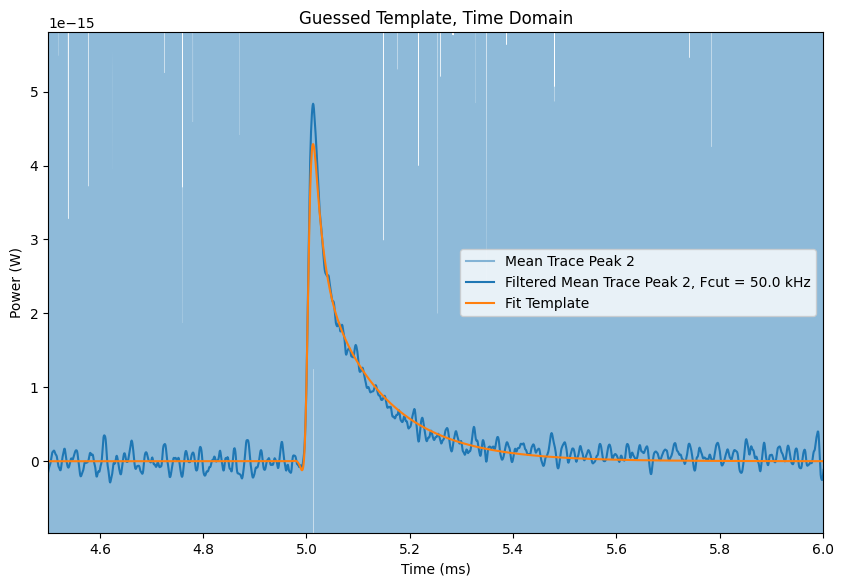

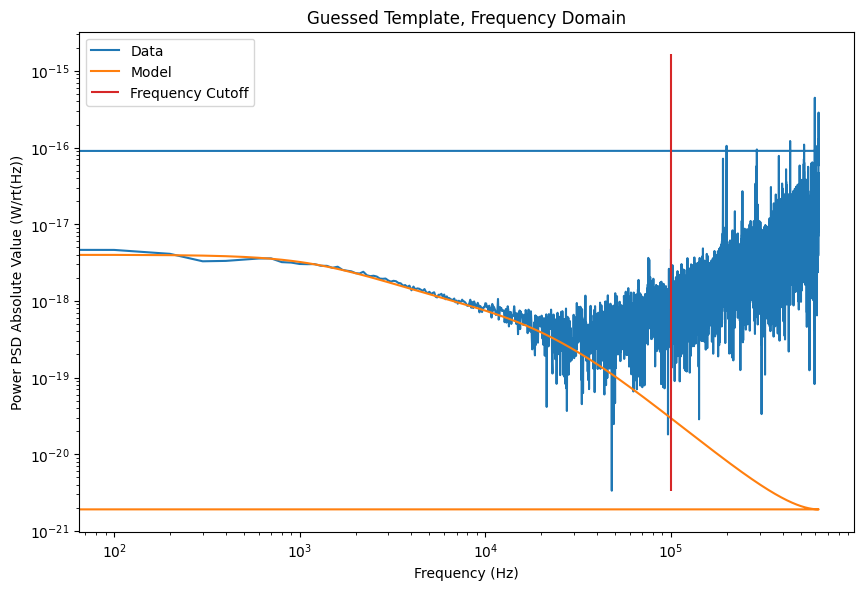

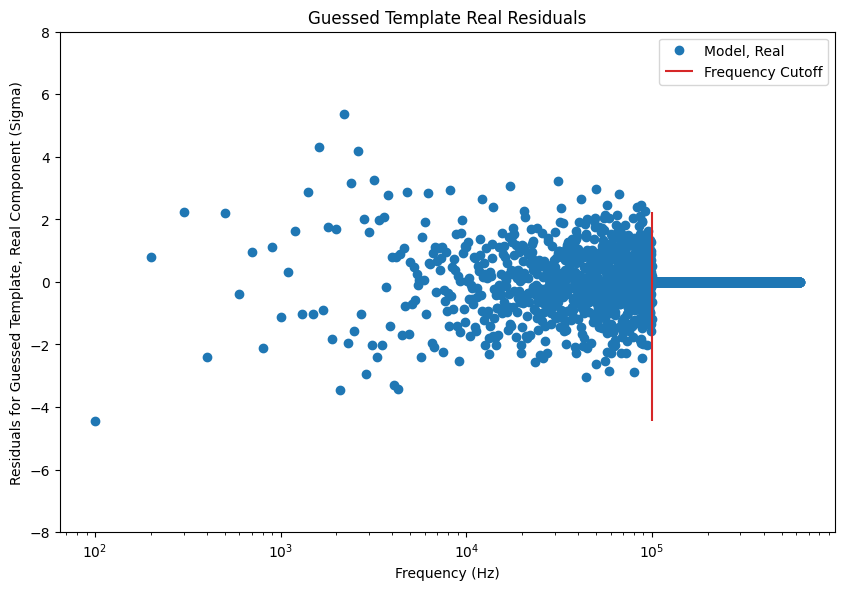

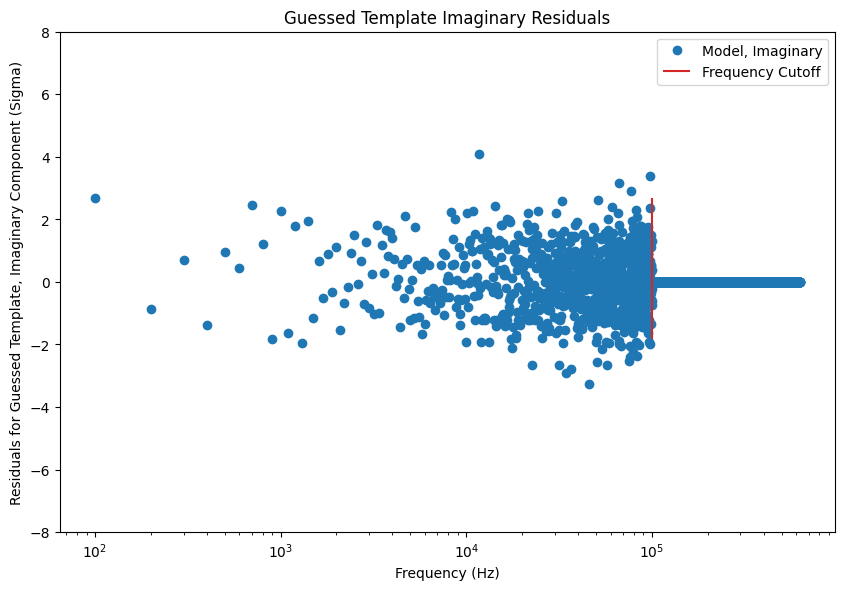

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.2668e+03                                    1.07e+18    
       1              4         2.0021e+03      2.65e+02       7.56e-06       1.30e+17    
       2              6         2.0005e+03      1.62e+00       3.78e-06       9.25e+16    
       3              9         1.9997e+03      7.84e-01       4.72e-07       1.37e+16    
       4             11         1.9996e+03      1.66e-02       2.36e-07       2.88e+14    
       5             13         1.9996e+03      9.86e-04       1.18e-07       1.79e+15    
`ftol` termination condition is satisfied.
Function evaluations 13, initial cost 2.2668e+03, final cost 1.9996e+03, first-order optimality 1.79e+15.


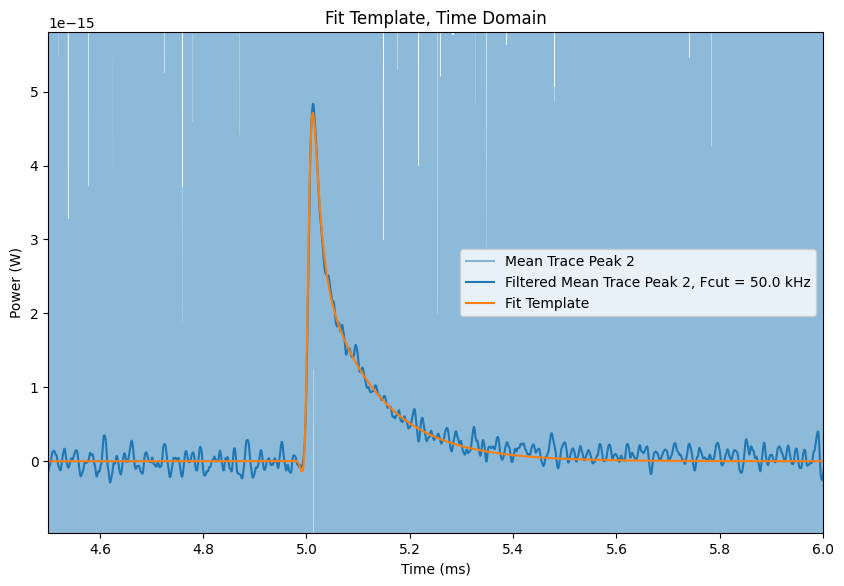

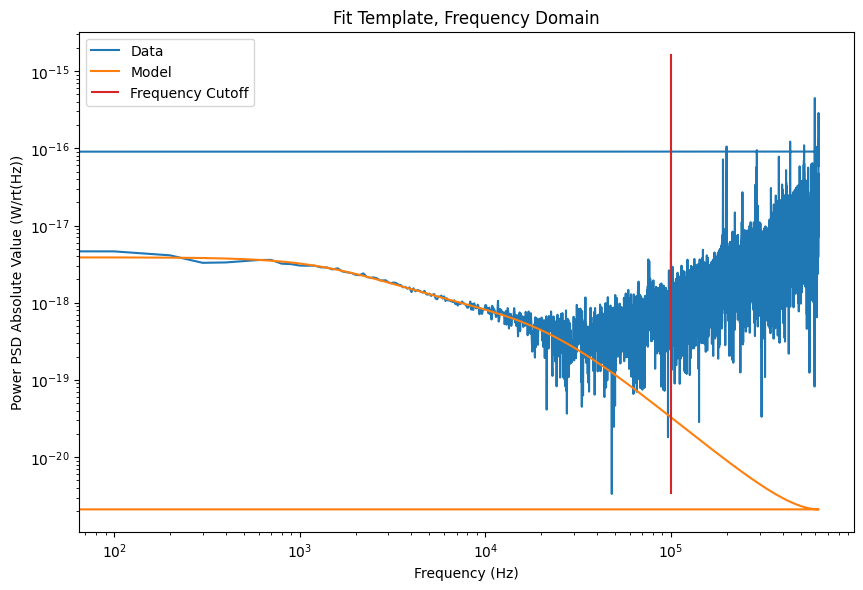

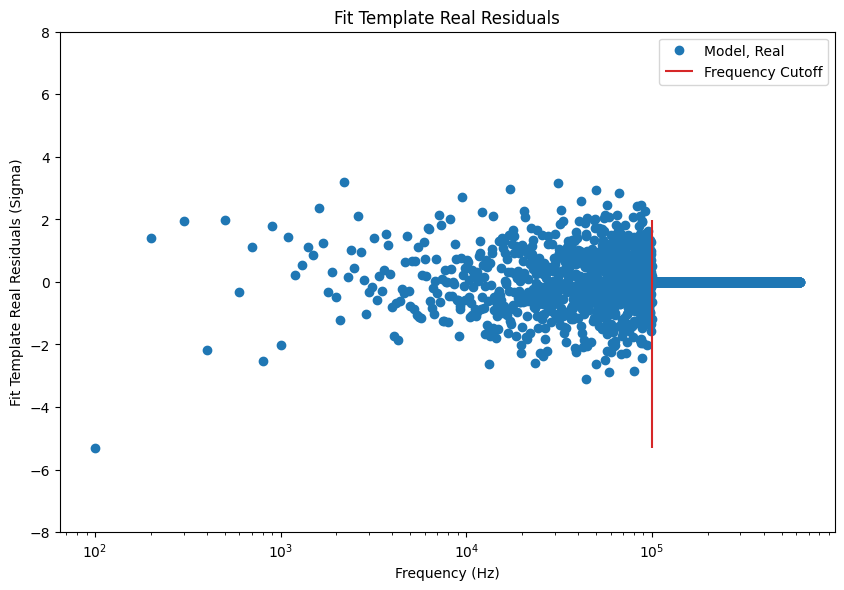

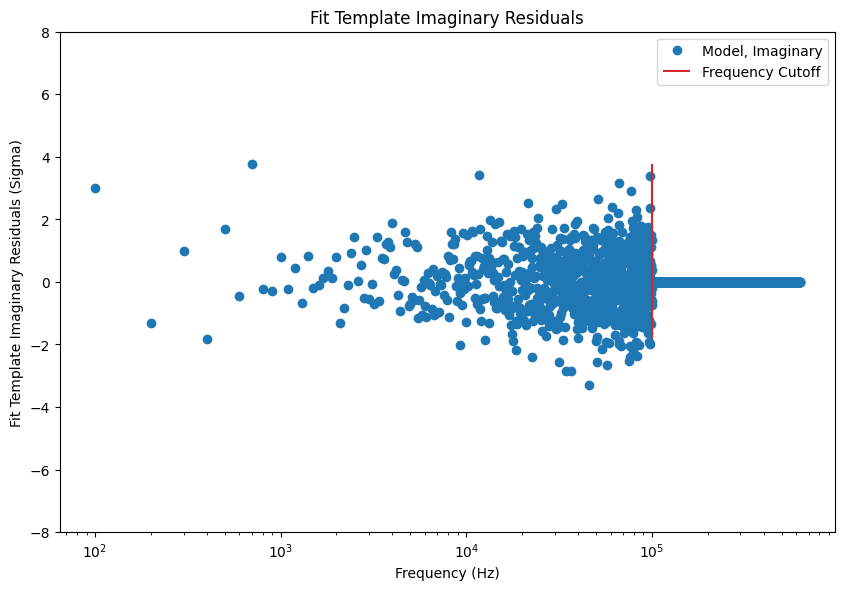

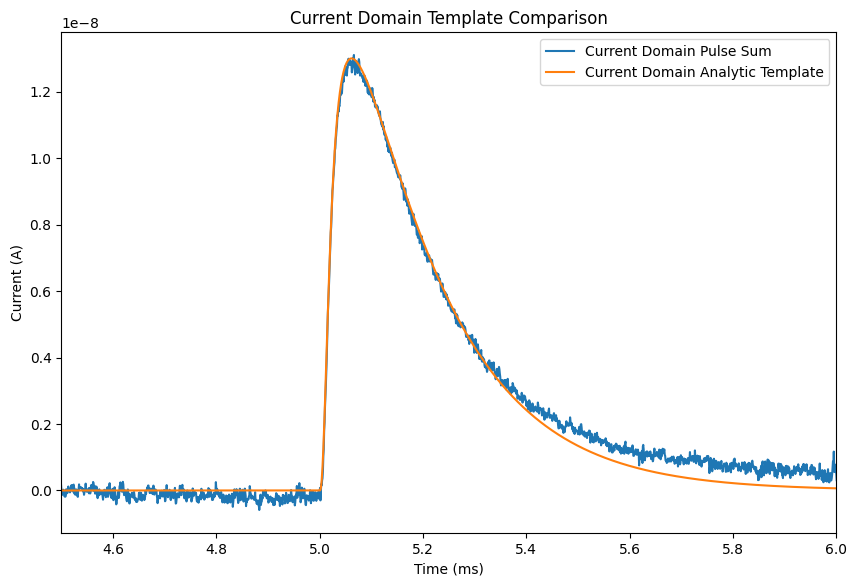

popt: 
[2.57355673e-15 2.50804171e-15 1.03489444e-05 1.09291048e-04
 6.57092127e-06]
 
cov:
[[ 3.70662367e-32 -1.29027637e-32 -3.84958446e-22 -1.39015289e-22
   2.38187734e-22]
 [-1.29027637e-32  5.14248599e-33  1.26766219e-22  2.59950015e-23
  -8.37957736e-23]
 [-3.84958446e-22  1.26766219e-22  4.22292933e-12  2.01206693e-12
  -2.54420701e-12]
 [-1.39015289e-22  2.59950015e-23  2.01206693e-12  2.70269636e-12
  -1.06666784e-12]
 [ 2.38187734e-22 -8.37957736e-23 -2.54420701e-12 -1.06666784e-12
   1.58546808e-12]]
 
Amplitude 1: 2.573556729328437e-15 +/- 1.9252593776709872e-16
Amplitude 2: 2.508041705187639e-15 +/- 7.17111287824377e-17
Fall Time 1: 10.348944371462293 +/- 2.0549767236999905 us
Fall Time 2: 109.29104787327563 +/- 1.643987943325663 us
Rise Time: 6.570921268706577 +/- 1.2591537177247756 us


In [18]:
guess_2p = [2.0e-15, 2.5e-15, 14e-6, 120e-6, 5.5e-6]
cal_4pc.fit_templates(2, guess = guess_2p,
                      f_fit_cutoff=100e3, filter_freq=50e3, 
                       max_nfev = 1000, time_lims=[4.5e-3, 6e-3])

To help visualize the covariance between different variables, we can show a correlation matrix. 

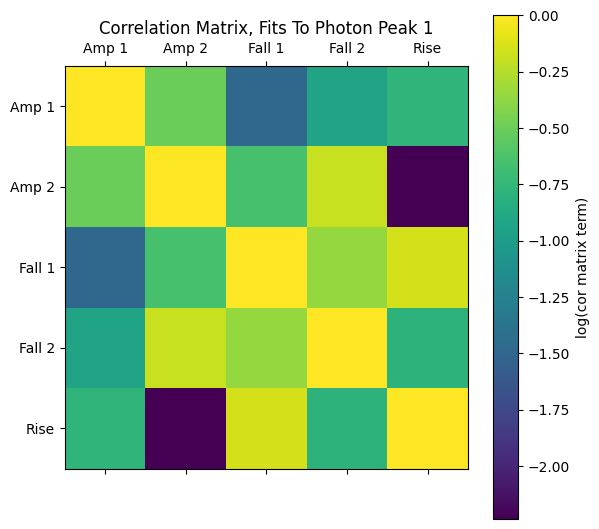

In [19]:
cal_4pc.get_correlation_matrix_visualization(photon_peak_number=1)

We can also print out tables of the fit results to see if there's significant amplitude or fall time differences between the first and higher energy peaks.

In [20]:
cal_4pc.print_fits_comparison_table()

Tables of Template Fit Parameters
Model: twopulse
 
------------------
 
 
Not Scaling Heights
 
  Photon Peak      Height 1    Height 1 Err      Height 2    Height 2 Err
-------------  ------------  --------------  ------------  --------------
            0  -1e-18           1.30575e-15  -1e-18           1.3268e-15
            1   1.1541e-15      4.52629e-17   1.23892e-15     4.17351e-17
            2   2.57356e-15     1.92526e-16   2.50804e-15     7.17111e-17
 
--------------------
 
Scaling Peak Heights, Scaled To First Photon Peak
 
  Photon Peak     Height 1    Height 1 Err     Height 2    Height 2 Err
-------------  -----------  --------------  -----------  --------------
            1  1.1541e-15      4.52629e-17  1.23892e-15     4.17351e-17
            2  1.28678e-15     9.6263e-17   1.25402e-15     3.58556e-17
 
-------------------
 
Fall Times: 
 
  Photon Peak    Fall 1 (us)    Fall 1 Err (us)    Fall 2 (us)    Fall 2 Err (us)    Rise (us)    Rise Err (us)
-------------  ---

Since we've selected events from specific peaks, and we've kept track of the normalization of the pulse height when doing fits, we can used the fit pulse shapes to learn about the energy contained in the template (which is just the integral in the power domain of the template). We can also use this to calculate the collection efficiency.

Since we know the covariance matrices of the fit models, we can also calculate the uncertainty in say the phonon collection efficiency correctly accounting for the fit variable covariances. This is done by numerically evaluating the Jacobian of the template integral, and multiplying by the covariance matrix.

In [21]:
cal_4pc.get_template_energy_uncertainty(photon_peak_number=1)
print(" ")
print(" ")
cal_4pc.get_template_phonon_collection_effiency(photon_peak_number=1)
print(" ")
print(" ")
_= cal_4pc.get_template_phonon_collection_effiency(photon_peak_number=2)

Energy in template: 2.0198069828984697e-19 +/- 2.8393490449201545e-21 J
Energy in template: 1.2607635187252249 +/- 0.017723216738391605 eV
 
 
Energy in template: 2.0198069828984697e-19 +/- 2.8393490449201545e-21 J
Energy in template: 1.2607635187252249 +/- 0.017723216738391605 eV
Photon Energy in Peak: 4.903722e-19 J
Phonon Collection Efficiency: 0.4118926364297303 +/- 0.0057901917052397235
 
 
Energy in template: 3.867680931552844e-19 +/- 2.5716807592930895e-21 J
Energy in template: 2.4142064374752854 +/- 0.016052431299507463 eV
Photon Energy in Peak: 9.807444e-19 J
Phonon Collection Efficiency: 0.3943617655683626 +/- 0.0026221722594521974


Looking back at the template fits, it looks like there's an additional slow component of the pulse that we're not fitting correctly. Let's now try to fit the pulse shape with a model that's the sum of three exponential pulses.

Guess: [2.9e-15, 2.5e-15, 1e-16, 1.2e-05, 0.00011, 0.001, 7.5e-06]
Bounds lower: [2.8e-15, 2.4e-15, 8e-17, 1e-05, 8e-05, 0.0008, 7e-06]
Bounds upper: [3e-15, 2.6e-15, 2.5e-16, 1.4e-05, 0.00012, 0.003, 8e-06]


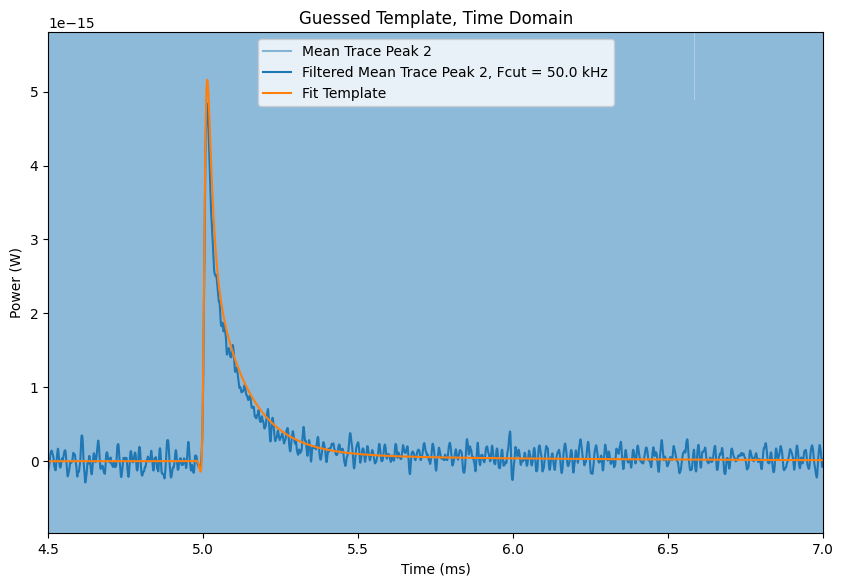

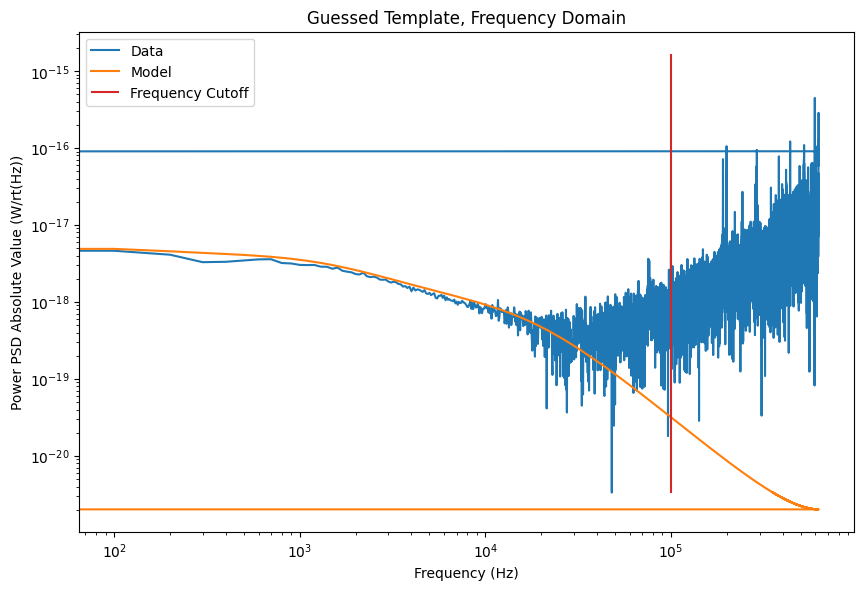

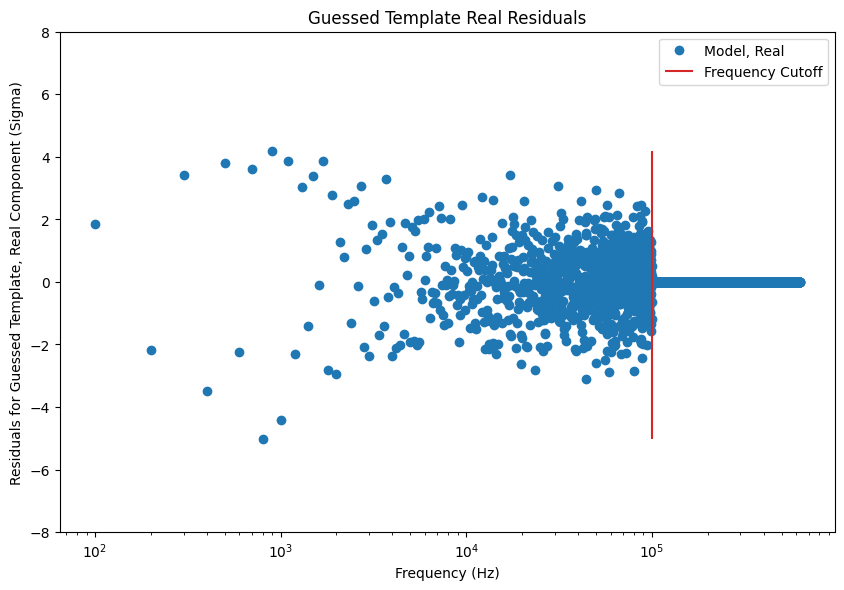

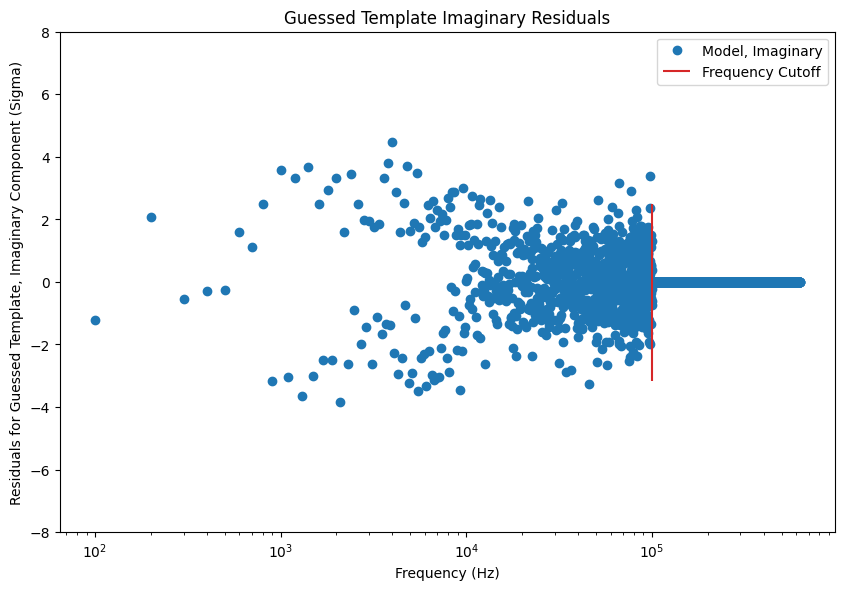

Using bounds for fit
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         3.0519e+03                                    6.40e+02    
       1              2         2.2464e+03      8.05e+02       4.03e-05       1.41e+02    
       2              3         2.0544e+03      1.92e+02       1.81e-05       3.40e+01    
       3              4         1.9991e+03      5.53e+01       1.02e-04       7.80e+00    
       4              5         1.9826e+03      1.65e+01       6.52e-05       1.59e+00    
       5              6         1.9783e+03      4.30e+00       2.58e-05       1.70e+00    
       6              7         1.9776e+03      6.76e-01       6.82e-06       2.55e-02    
       7              8         1.9776e+03      3.58e-02       2.74e-07       5.35e-03    
       8              9         1.9776e+03      1.82e-04       6.39e-08       2.60e-04    
`ftol` termination condition is satisfied.
Function evaluations 9, in

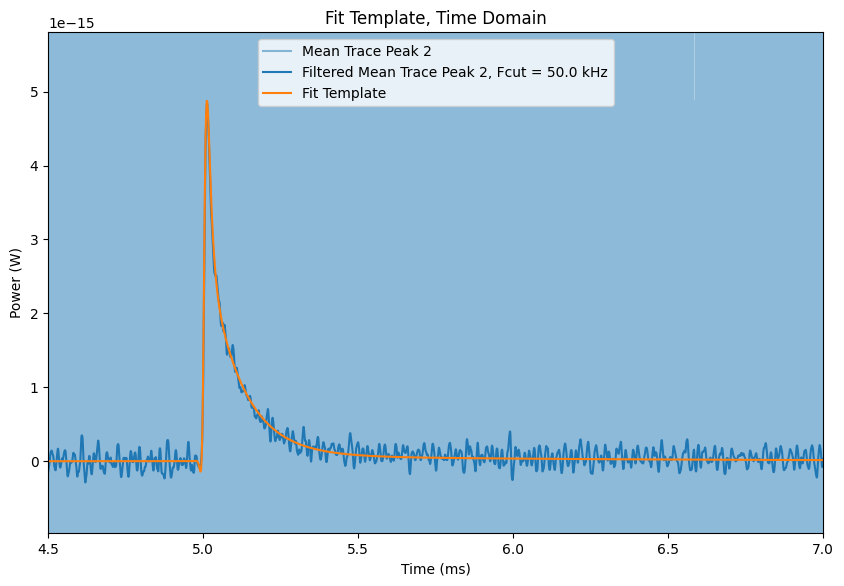

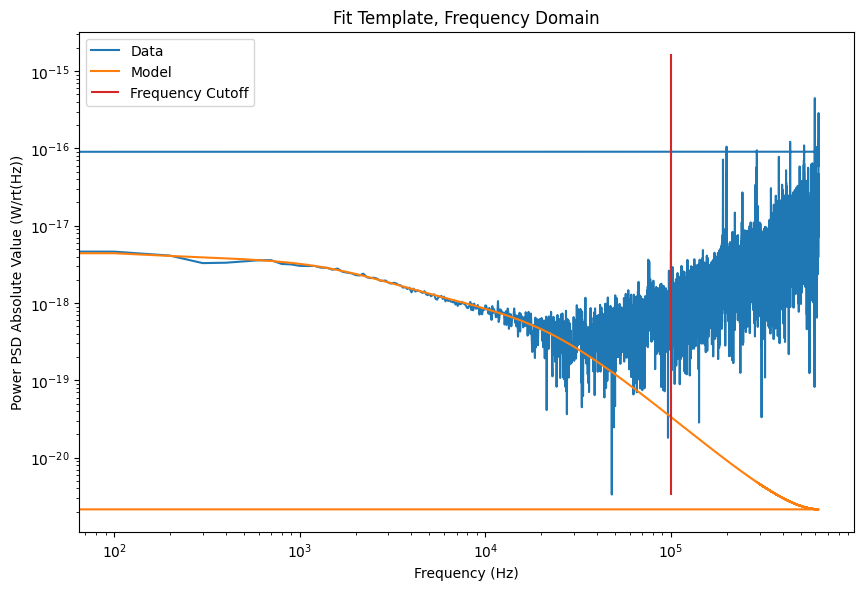

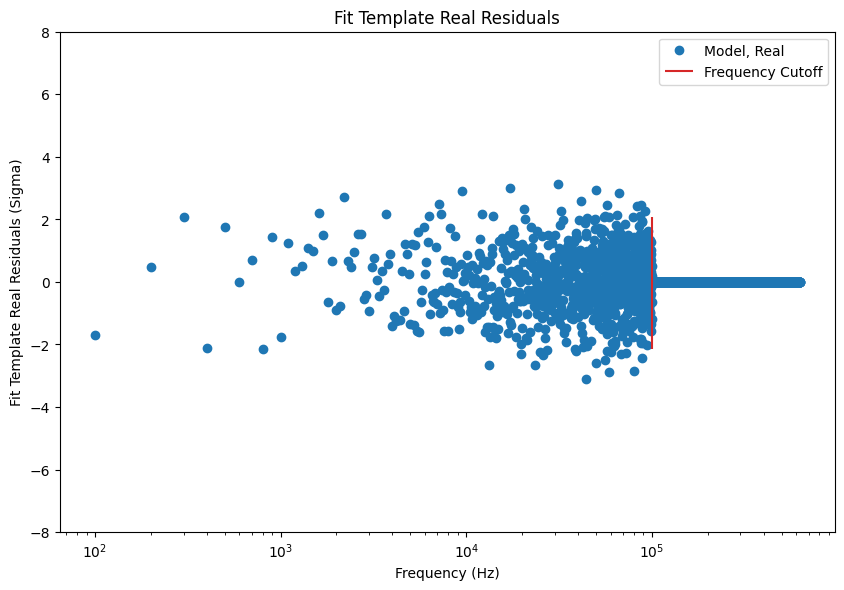

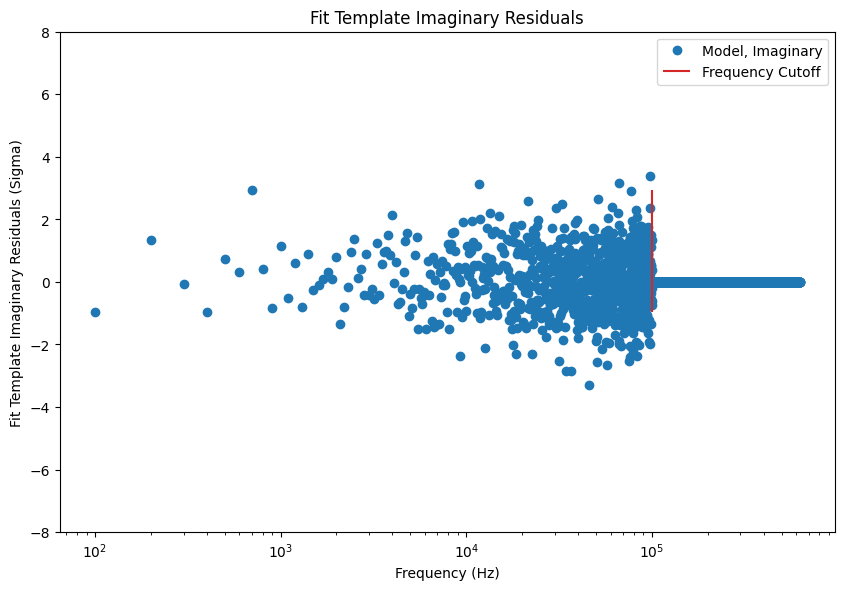

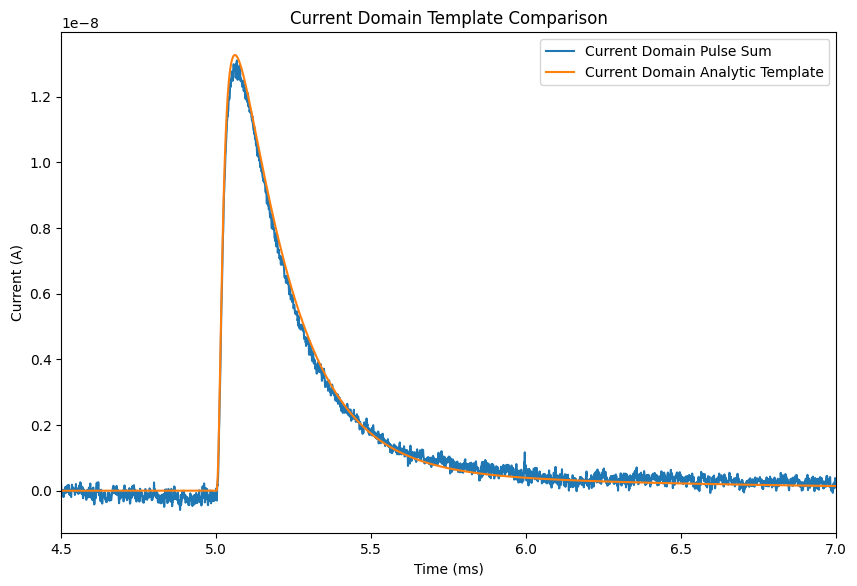

popt: 
[2.80000000e-15 2.40000000e-15 8.00000033e-17 1.00000000e-05
 1.06195669e-04 1.17805315e-03 7.00000000e-06]
 
cov:
[[ 5.70389603e-32 -2.19177046e-32  5.93347778e-34 -5.64644549e-22
  -2.62005148e-22 -8.18285160e-21  3.84757342e-22]
 [-2.19177046e-32  9.14262909e-33 -3.35765013e-34  2.11905532e-22
   8.79587552e-23  4.82566537e-21 -1.49451008e-22]
 [ 5.93347778e-34 -3.35765013e-34  2.96097019e-34 -8.91207671e-24
  -2.93560738e-23 -3.79721176e-21  4.99017063e-24]
 [-5.64644549e-22  2.11905532e-22 -8.91207671e-24  5.80805135e-12
   3.39719082e-12  1.16083291e-10 -3.88732767e-12]
 [-2.62005148e-22  8.79587552e-23 -2.93560738e-23  3.39719082e-12
   5.89717624e-12  3.56463973e-10 -2.03594899e-12]
 [-8.18285160e-21  4.82566537e-21 -3.79721176e-21  1.16083291e-10
   3.56463973e-10  6.81630215e-08 -6.69842128e-11]
 [ 3.84757342e-22 -1.49451008e-22  4.99017063e-24 -3.88732767e-12
  -2.03594899e-12 -6.69842128e-11  2.65780748e-12]]
 
Amplitude 1: 2.800000000002492e-15 +/- 2.388283071259777

In [22]:
cal_4pc.template_model='threepulse'
guess_2p = [2.9e-15, 2.5e-15, 1e-16, 12e-6, 110e-6, 1e-3, 7.5e-6]
bounds_2p = [[2.8e-15, 2.4e-15, 8e-17, 10e-6, 80e-6, 800e-6, 7e-6],
             [3.0e-15, 2.6e-15, 25e-17, 14e-6, 120e-6, 3e-3, 8e-6]
            ]

cal_4pc.fit_templates(2, #photon peak number to fit
                      guess = guess_2p, 
                      bounds = bounds_2p, 
                      f_fit_cutoff=100e3, #above a certain frequency, basically all the template informatio
                                          #is just noise. This cutoff prevents the noise from being fit by
                                          #setting the weights to zero. This is similar to a low frequency
                                          #chi2, conceptually
                      filter_freq=50e3, #The low pass filter frequency for plotting
                      time_lims=[4.5e-3, 7e-3] #time limits for the diagnostic plots
                      )

Guess: [1.45e-15, 1.25e-15, 5e-17, 1.2e-05, 0.00011, 0.001, 7.5e-06]
Bounds lower: [1.4e-15, 1.2e-15, 4e-17, 1e-05, 8e-05, 0.0008, 7e-06]
Bounds upper: [1.5e-15, 1.3e-15, 1.4e-16, 1.4e-05, 0.00012, 0.003, 8e-06]


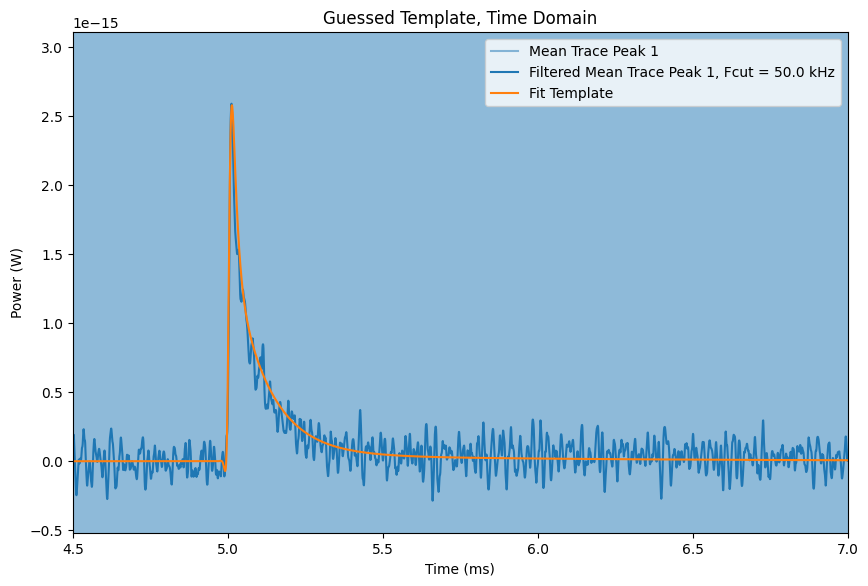

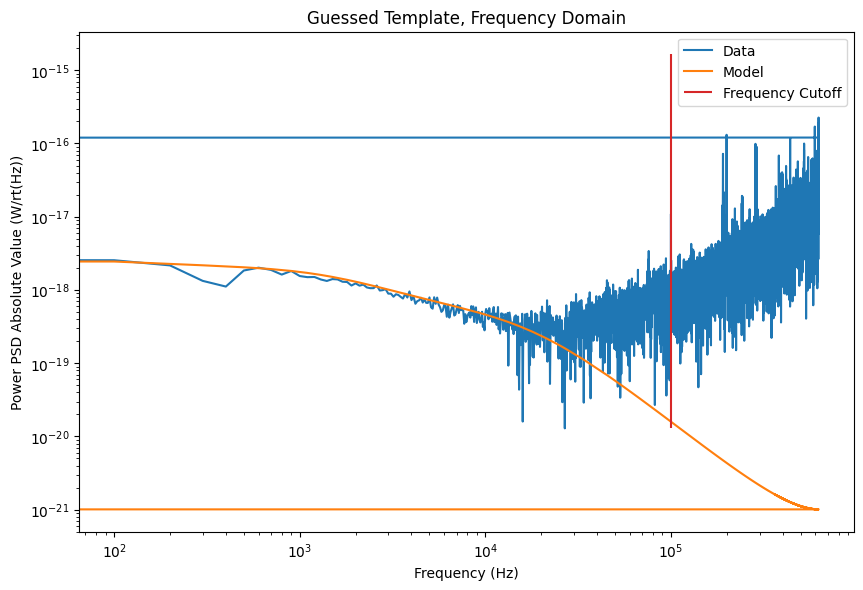

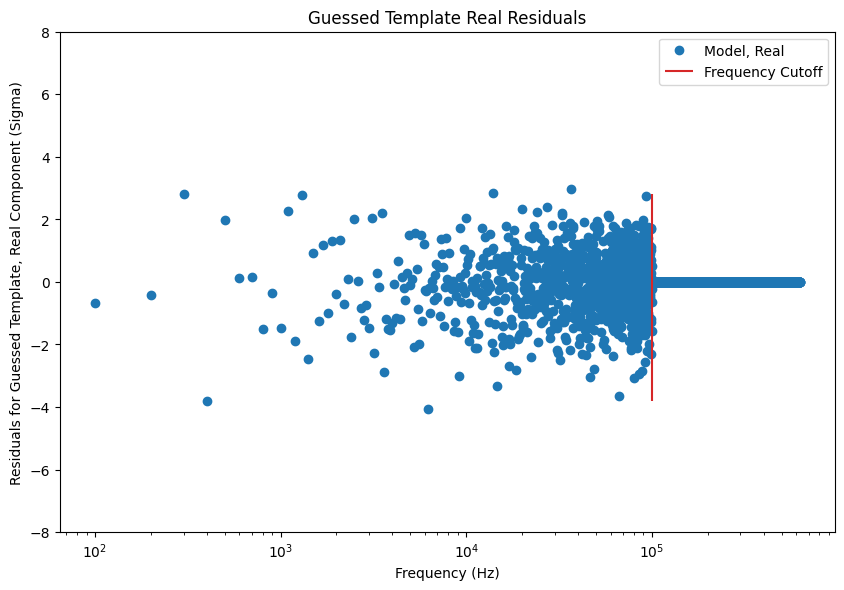

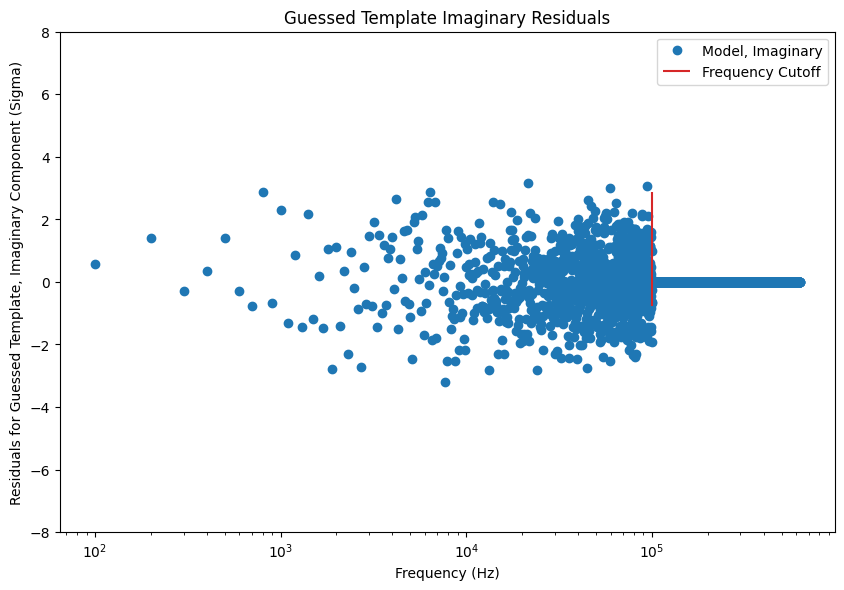

Using bounds for fit
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.3229e+03                                    1.54e+02    
       1              2         2.1487e+03      1.74e+02       3.13e-05       3.34e+01    
       2              3         2.1102e+03      3.85e+01       1.47e-04       8.53e+00    
       3              4         2.1007e+03      9.55e+00       1.36e-04       2.18e+00    
       4              5         2.0983e+03      2.37e+00       8.28e-05       5.96e-01    
       5              6         2.0972e+03      1.10e+00       7.10e-05       7.39e-02    
       6              7         2.0971e+03      6.78e-02       3.07e-05       3.41e-02    
       7              8         2.0971e+03      1.54e-03       8.34e-06       7.94e-02    
`ftol` termination condition is satisfied.
Function evaluations 8, initial cost 2.3229e+03, final cost 2.0971e+03, first-order optimality 7.94e-02.


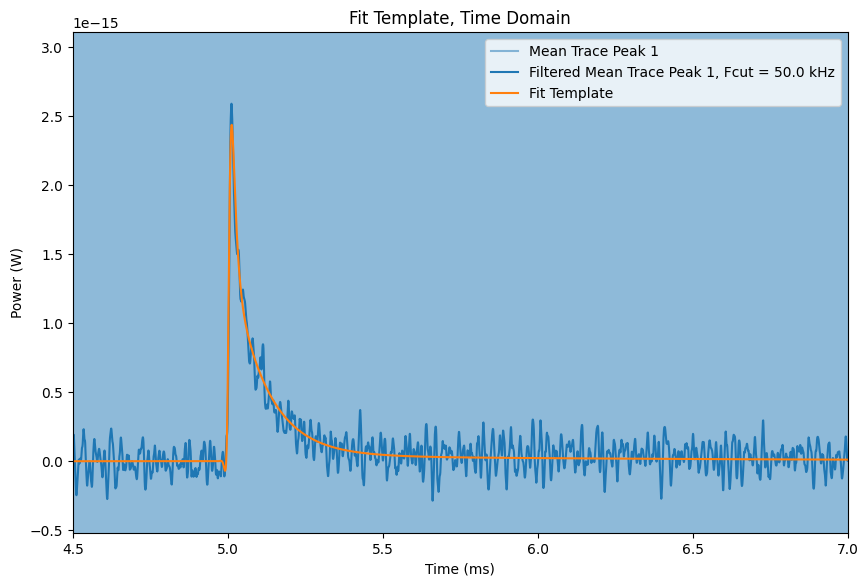

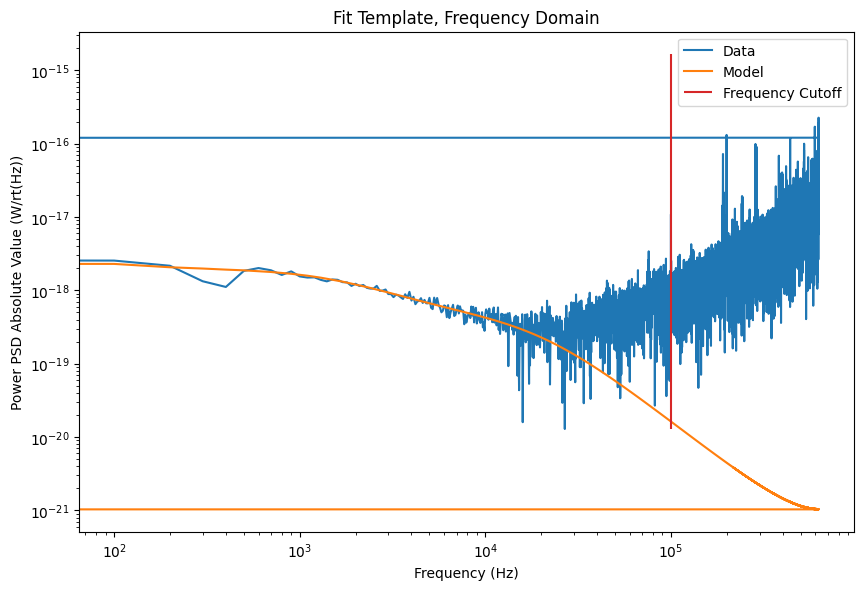

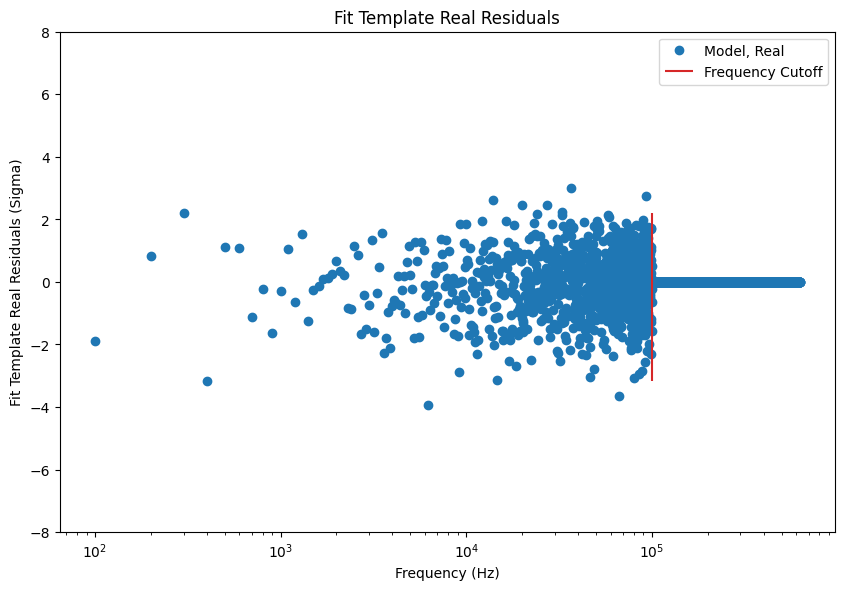

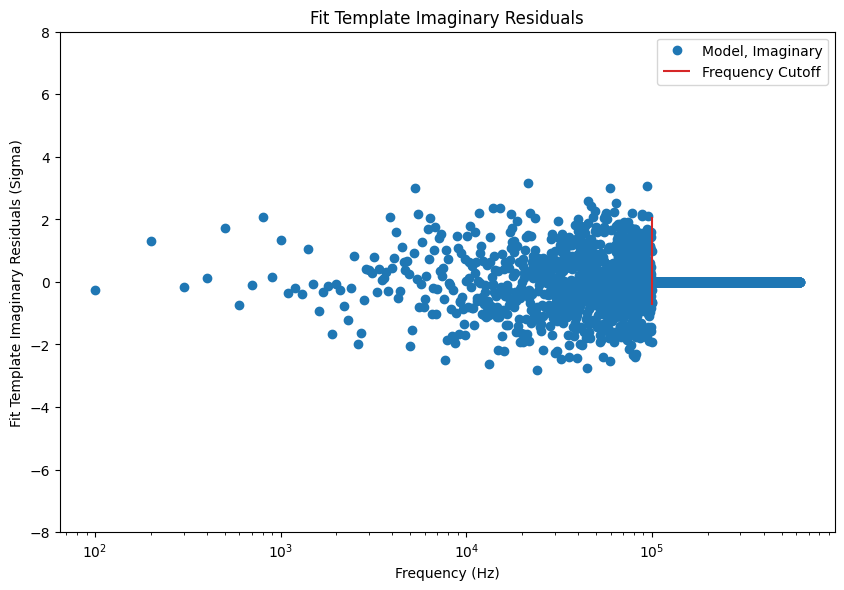

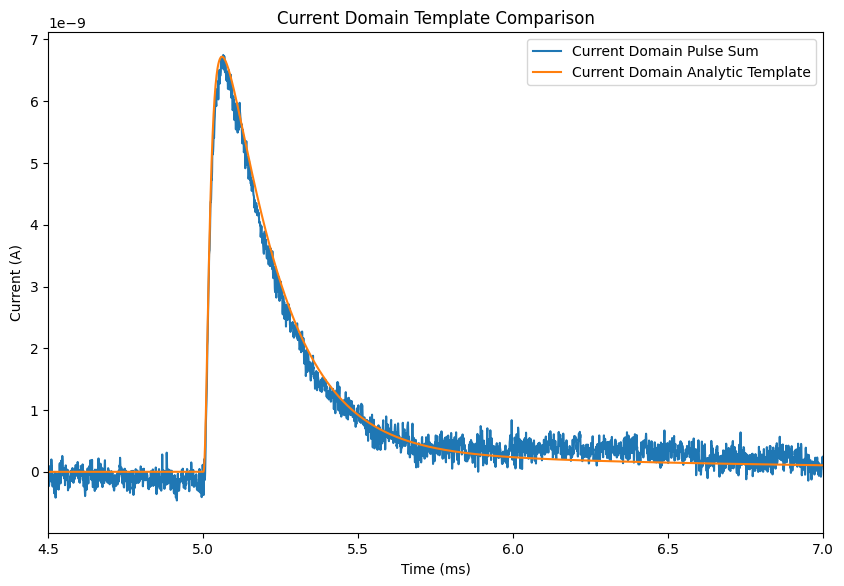

popt: 
[1.40000000e-15 1.20000001e-15 4.21797244e-17 1.00000000e-05
 1.07661941e-04 1.50663717e-03 7.35466476e-06]
 
cov:
[[ 7.80188304e-32 -3.03740363e-32  4.65139121e-34 -1.48615061e-21
  -5.84182232e-22 -1.86457515e-20  1.06699545e-21]
 [-3.03740363e-32  1.24136490e-32 -2.38893577e-34  5.68229339e-22
   1.98894200e-22  9.57424324e-21 -4.17566227e-22]
 [ 4.65139121e-34 -2.38893577e-34  1.76666413e-34 -1.29830202e-23
  -3.80754560e-23 -5.75575286e-21  7.77103398e-24]
 [-1.48615061e-21  5.68229339e-22 -1.29830202e-23  2.91266572e-11
   1.39572153e-11  4.80088084e-10 -2.06158583e-11]
 [-5.84182232e-22  1.98894200e-22 -3.80754560e-23  1.39572153e-11
   1.98405278e-11  1.21201417e-09 -8.98599285e-12]
 [-1.86457515e-20  9.57424324e-21 -5.75575286e-21  4.80088084e-10
   1.21201417e-09  2.75913450e-07 -2.99560464e-10]
 [ 1.06699545e-21 -4.17566227e-22  7.77103398e-24 -2.06158583e-11
  -8.98599285e-12 -2.99560464e-10  1.48230260e-11]]
 
Amplitude 1: 1.4000000029831563e-15 +/- 2.79318510710373

In [23]:
guess_1p = [1.45e-15, 1.25e-15, 0.5e-16, 12e-6, 110e-6, 1e-3, 7.5e-6]
bounds_1p = [[1.4e-15, 1.2e-15, 4e-17, 10e-6, 80e-6, 800e-6, 7e-6],
             [1.5e-15, 1.3e-15, 14e-17, 14e-6, 120e-6, 3e-3, 8e-6]
            ]

cal_4pc.fit_templates(1, #photon peak number to fit
                      guess = guess_1p, 
                      bounds=bounds_1p, 
                      f_fit_cutoff=100e3, #above a certain frequency, basically all the template informatio
                                          #is just noise. This cutoff prevents the noise from being fit by
                                          #setting the weights to zero. This is similar to a low frequency
                                          #chi2, conceptually
                      filter_freq=50e3, #The low pass filter frequency for plotting
                      time_lims=[4.5e-3, 7e-3] #time limits for the diagnostic plots
                      )

In [24]:
guess_0p = [0.0e-15, 0.0e-15, 0.0e-16, 12e-6, 110e-6, 1e-3, 7.5e-6]
bounds_0p = [[-1.4e-19, -1.2e-19, -4e-19, 10e-6, 80e-6, 800e-6, 7e-6],
             [1.5e-19, 1.3e-19, 14e-19, 14e-6, 120e-6, 3e-3, 8e-6]
            ]

cal_4pc.fit_templates(0, #photon peak number to fit
                      guess = guess_0p, 
                      bounds=bounds_0p, 
                      f_fit_cutoff=100e3, #above a certain frequency, basically all the template informatio
                                          #is just noise. This cutoff prevents the noise from being fit by
                                          #setting the weights to zero. This is similar to a low frequency
                                          #chi2, conceptually
                      filter_freq=50e3, #The low pass filter frequency for plotting
                      time_lims=[4.5e-3, 7e-3], #time limits for the diagnostic plots
                      lgc_plot=False
                      )

Guess: [0.0, 0.0, 0.0, 1.2e-05, 0.00011, 0.001, 7.5e-06]
Bounds lower: [-1.4e-19, -1.2e-19, -4e-19, 1e-05, 8e-05, 0.0008, 7e-06]
Bounds upper: [1.5e-19, 1.3e-19, 1.4e-18, 1.4e-05, 0.00012, 0.003, 8e-06]
Using bounds for fit
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         2.1470e+03                                    9.99e-01    
       1              2         2.1459e+03      1.09e+00       1.91e-04       1.48e-01    
       2              3         2.1458e+03      1.56e-01       2.07e-03       3.47e-03    
       3              4         2.1458e+03      4.04e-03       1.21e-04       1.67e-05    
       4              5         2.1458e+03      1.92e-05       6.17e-07       4.09e-10    
`gtol` termination condition is satisfied.
Function evaluations 5, initial cost 2.1470e+03, final cost 2.1458e+03, first-order optimality 4.09e-10.
popt: 
[-1.40000000e-19 -1.20000000e-19 -4.00000000e-19  1.40000000e-05
  1.200000

In [25]:
cal_4pc.get_template_phonon_collection_effiency(photon_peak_number=1)
print(" ")
print(" ")
_= cal_4pc.get_template_phonon_collection_effiency(photon_peak_number=2)

Energy in template: 2.5303498923640305e-19 +/- 1.079992310087297e-20 J
Energy in template: 1.5794444028136279 +/- 0.06741311999564908 eV
Photon Energy in Peak: 4.903722e-19 J
Phonon Collection Efficiency: 0.51600598328454 +/- 0.022023930191950057
 
 
Energy in template: 4.689253392294333e-19 +/- 1.0488699429105267e-20 J
Energy in template: 2.9270319674701226 +/- 0.06547046183647508 eV
Photon Energy in Peak: 9.807444e-19 J
Phonon Collection Efficiency: 0.47813205890284294 +/- 0.010694630965117179


We can see that adding the third pole makes the fits somewhat better for long fall times, but way less stable (so we have to add bounds).

We also now have more energy from the pulse, as seen by the higher collection efficiency.

In [70]:
res,uncertainty = cal_4pc.get_spectrum_energy_res()
print(res)

Model used to fit peaks: three_gaus
Measuring energy resolution using photon energy
and peak width relative to peak spacing in OFAmp
 
Energy resolution: 0.5877581229735931 +/- 0.009427565345633857 eV
0.5877581229735931


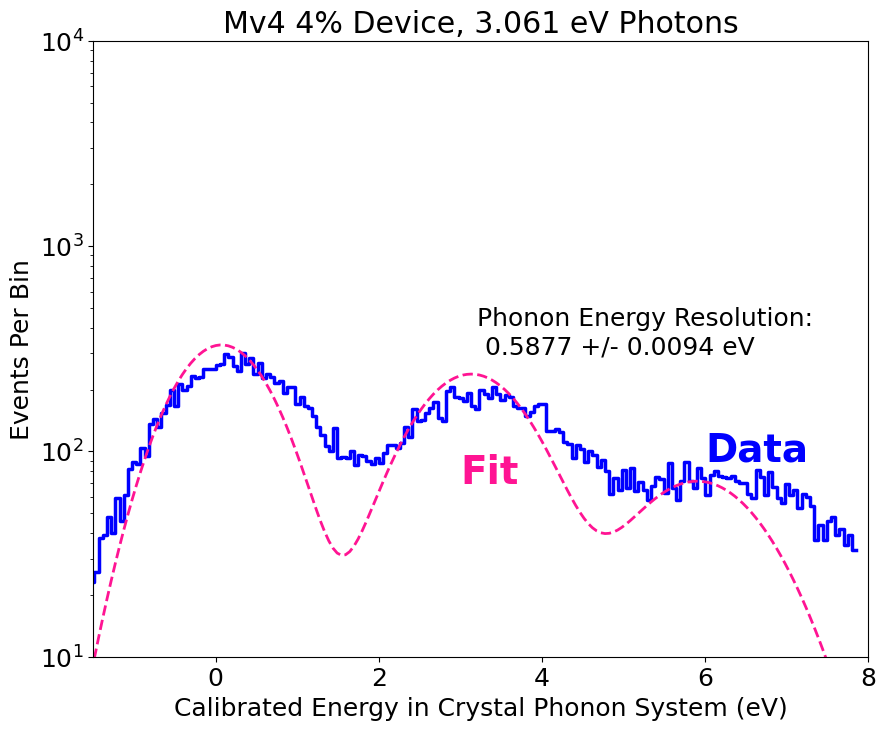

In [58]:
mpl.rcParams['figure.figsize'] = [10, 8]
font = {'size': 18}
mpl.rc('font', **font)
cal_4pc.get_nice_photon_spectrum_plot()
plt.title("Mv4 4% Device, 3.061 eV Photons")
plt.text(6.0, 90, "Data", color = 'Blue', fontweight='bold', fontsize = 28)
plt.text(3.0, 70, "Fit", color = 'deeppink', fontweight='bold', fontsize = 28)
plt.text(3.2, 300, "Phonon Energy Resolution:\n " + str(res)[:6] + " +/- " + str(uncertainty)[:6] + " eV")
plt.yscale('log')
plt.xlim(-1.5,8)
plt.ylim(1e1, 10e3)
plt.show()

plt.style.use('default')
mpl.rcParams['figure.figsize'] = [10, 6.5]

Finally, we can save the object if we want to work with it somewhere else.

In [35]:
save_name = 'photoncal_4pc_063023'

with open(save_name, 'wb') as handle:
    pickle.dump(cal_4pc, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [59]:
cal_4pc.print_fits_comparison_table()

Tables of Template Fit Parameters
Model: threepulse
 
------------------
 
 
Not Scaling Heights
 
  Photon Peak    Height 1    Height 1 Err    Height 2    Height 2 Err      Height 3    Height 3 Err
-------------  ----------  --------------  ----------  --------------  ------------  --------------
            0    -1.4e-19     2.76064e-16    -1.2e-19     3.1047e-17   -4e-19           1.21588e-17
            1     1.4e-15     2.79319e-16     1.2e-15     1.11417e-16   4.21797e-17     1.32916e-17
            2     2.8e-15     2.38828e-16     2.4e-15     9.56171e-17   8e-17           1.72075e-17
 
--------------------
 
Scaling Peak Heights, Scaled To First Photon Peak
 
  Photon Peak    Height 1    Height 1 Err    Height 2    Height 2 Err     Height 3    Height 3 Err
-------------  ----------  --------------  ----------  --------------  -----------  --------------
            1     1.4e-15     2.79319e-16     1.2e-15     1.11417e-16  4.21797e-17     1.32916e-17
            2     1.4e-15  

We also can get and plot a template in current domain from a photon peak. This could also be saved to an hdf5 filter file and used for processing!

Calculating dPdI! This may take some time.


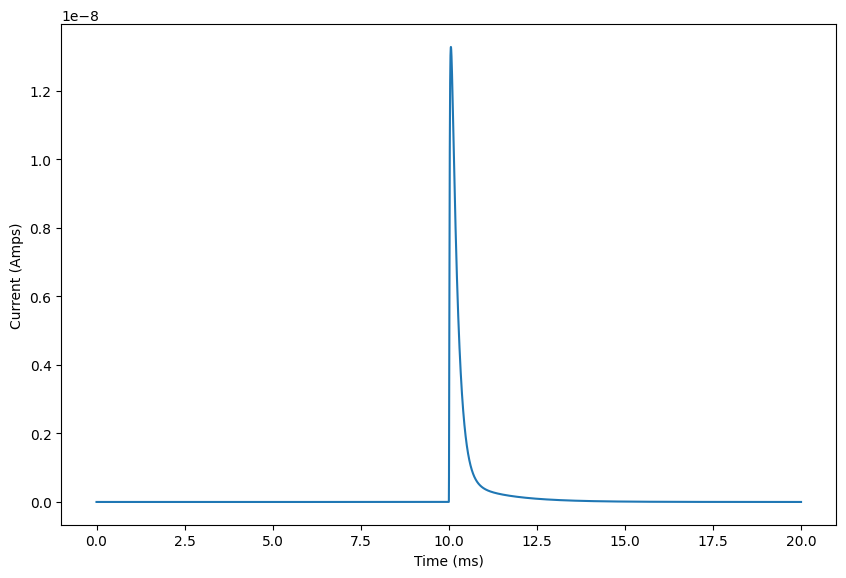

In [62]:
t_arr = np.arange(0, 20e-3, 1/(1.25e6))
start_time = 10e-3

template_4 = cal_4pc.get_current_template(2, result_4, t_arr, start_time=start_time)

In [63]:
from detprocess import Template

In [64]:
template_obj = Template(verbose=True)

In [67]:
template_obj.set_template('Melange4pc1ch', template_4, sample_rate=1.25e6, pretrigger_length_msec=10)

In [68]:
#template_obj.save_hdf5('Melange4pc1ch_Template20ms', overwrite=True)
#you can specify a file path, and uncomment the above to save the filter file with your template
#to check how things look you can then run
#template_obj.load_hdf5('Melange4pc1ch_Template20ms', overwrite=False)
#template_obj.describe()

What we have now is a template which corresponds to real phonon events in our detector. We also have an understanding of how much energy was absorbed into our TES, using the most correct template for these events, and how much energy is in the phonon system (applying the phonon collection efficiency that we extracted).